In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading and preprocessing all datasets...
Loaded Sentiment140 Finance dataset: 2000 rows
Loaded Twitter Financial News dataset: 2000 rows
Loaded Weibo Translated dataset: 2000 rows
Loaded PhraseBank dataset: 2000 rows

Column names in each dataset:
Sentiment140: ['target', 'id', 'date', 'flag', 'user', 'text']
Twitter Financial: ['text', 'label']
Weibo: ['id', 'user_id', '用户昵称', '性别', '地区', '认证', '用户类别', 'text', 'ip', '发布时间', 'translated_text', 'source']
PhraseBank: ['Unnamed: 0', 'TWEET', 'STOCK', 'DATE', 'LAST_PRICE', '1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN', 'PX_VOLUME', 'VOLATILITY_10D', 'VOLATILITY_30D', 'LSTM_POLARITY', 'TEXTBLOB_POLARITY']

Processing Sentiment140 dataset...
Sentiment140 sentiment values: ['"1970973843"' '"1986665297"' '"1833943087"' '"1573244092"'
 '"1564248061"' '"1972898410"' '"1988737713"' '"1965367280"'
 '"1880684862"' '"1967772090"']
 1.69359685e+09 1.82392119e+09]

Processing Twitter Financial News dataset...
First row of Twitter dat

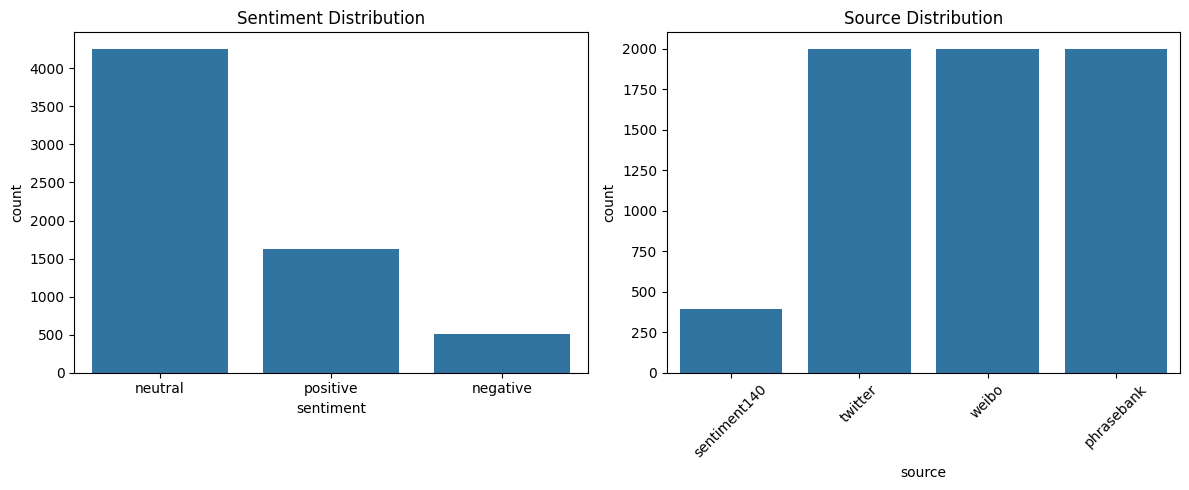

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

def load_and_preprocess_datasets():
    print("Loading and preprocessing all datasets...")

    # 1. Load each dataset
    try:
        # Sentiment140 Finance sample
        sentiment140_df = pd.read_csv("/content/sentiment140_2000.csv")
        print(f"Loaded Sentiment140 Finance dataset: {len(sentiment140_df)} rows")

        # Twitter Financial News
        twitter_fin_df = pd.read_csv("/content/twitter_financial_news.csv")
        print(f"Loaded Twitter Financial News dataset: {len(twitter_fin_df)} rows")

        # Weibo Translated
        weibo_df = pd.read_csv("/content/translated_weibo_sample.csv")
        print(f"Loaded Weibo Translated dataset: {len(weibo_df)} rows")

        # PhraseBank
        phrasebank_df = pd.read_csv("/content/phrasebank_sample_2000.csv")
        print(f"Loaded PhraseBank dataset: {len(phrasebank_df)} rows")

    except FileNotFoundError as e:
        print(f"Error: Could not find file. {str(e)}")
        print("Make sure all four CSV files are in the current directory.")
        return None
    except Exception as e:
        print(f"Error loading datasets: {str(e)}")
        return None

    # 2. Explore and standardize each dataset structure

    # Print column names for each dataset
    print("\nColumn names in each dataset:")
    print(f"Sentiment140: {sentiment140_df.columns.tolist()}")
    print(f"Twitter Financial: {twitter_fin_df.columns.tolist()}")
    print(f"Weibo: {weibo_df.columns.tolist()}")
    print(f"PhraseBank: {phrasebank_df.columns.tolist()}")

    # Process Sentiment140 - Map sentiment values (0=negative, 2=neutral, 4=positive) to standardized format
    try:
        print("\nProcessing Sentiment140 dataset...")
        # Check if target column exists
        if 'target' in sentiment140_df.columns:
            print(f"Sentiment140 sentiment values: {sentiment140_df['target'].unique()[:10]}")

            # Try to convert target to numeric if it's not already
            if sentiment140_df['target'].dtype == 'object':
                try:
                    sentiment140_df['target'] = pd.to_numeric(sentiment140_df['target'])
                except:
                    # If direct conversion fails, try extracting numbers from strings
                    sentiment140_df['target'] = sentiment140_df['target'].str.extract('(\d+)').astype(float)

            # Map sentiment values
            sentiment_map = {0: 'negative', 2: 'neutral', 4: 'positive'}
            sentiment140_df['sentiment'] = sentiment140_df['target'].map(sentiment_map)

            # For any unmapped values, use a default
            if sentiment140_df['sentiment'].isna().any():
                print(f"Warning: Some sentiment values couldn't be mapped: {sentiment140_df[sentiment140_df['sentiment'].isna()]['target'].unique()}")
                # If the target is a number close to 0, 2, or 4, map it accordingly
                for i, val in enumerate([0, 2, 4]):
                    mask = (sentiment140_df['target'] >= val-0.5) & (sentiment140_df['target'] < val+0.5) & sentiment140_df['sentiment'].isna()
                    sentiment140_df.loc[mask, 'sentiment'] = list(sentiment_map.values())[i]

                # Any remaining NaN values get assigned to 'neutral'
                sentiment140_df['sentiment'] = sentiment140_df['sentiment'].fillna('neutral')

            # Keep only needed columns and rename
            sentiment140_df = sentiment140_df[['text', 'sentiment']]
            sentiment140_df['source'] = 'sentiment140'
        else:
            print("Warning: 'target' column not found in Sentiment140 dataset")
            # Try alternative columns like 'sentiment', 'label', etc.
            alt_cols = ['sentiment', 'label', 'class', 'polarity']
            found = False
            for col in alt_cols:
                if col in sentiment140_df.columns:
                    print(f"Found alternative column: {col}")
                    sentiment140_df['sentiment'] = sentiment140_df[col]
                    sentiment140_df = sentiment140_df[['text', 'sentiment']]
                    sentiment140_df['source'] = 'sentiment140'
                    found = True
                    break

            if not found:
                print("Could not identify sentiment column in Sentiment140 dataset")
                return None
    except Exception as e:
        print(f"Error processing Sentiment140: {str(e)}")
        return None

    # Process Twitter Financial News dataset
    try:
        print("\nProcessing Twitter Financial News dataset...")
        # Examine the dataset to find text and sentiment columns
        print(f"First row of Twitter data: {twitter_fin_df.iloc[0]}")

        # Check various potential column names for text and sentiment
        text_col = None
        for col in ['text', 'Text', 'content', 'tweet', 'message']:
            if col in twitter_fin_df.columns:
                text_col = col
                break

        sentiment_col = None
        for col in ['sentiment', 'Sentiment', 'label', 'class']:
            if col in twitter_fin_df.columns:
                sentiment_col = col
                break

        if text_col and sentiment_col:
            # Keep only needed columns
            twitter_df_clean = twitter_fin_df[[text_col, sentiment_col]].copy()
            # Standardize column names
            twitter_df_clean.columns = ['text', 'sentiment']
            twitter_df_clean['source'] = 'twitter'

            # Check unique sentiment values
            print(f"Twitter sentiment values: {twitter_df_clean['sentiment'].unique()}")

            # Standardize sentiment labels if needed
            sentiment_value_mapping = {
                'positive': 'positive', 'Positive': 'positive', '1': 'positive', 1: 'positive', 2: 'positive',
                'negative': 'negative', 'Negative': 'negative', '-1': 'negative', -1: 'negative', 0: 'negative',
                'neutral': 'neutral', 'Neutral': 'neutral', '0': 'neutral', 1: 'neutral'
            }

            # Map sentiment values to standardized format
            twitter_df_clean['sentiment'] = twitter_df_clean['sentiment'].map(
                lambda x: sentiment_value_mapping.get(x, 'neutral'))  # Default to neutral for unknown values
        else:
            print(f"Warning: Could not identify text or sentiment columns in Twitter dataset")
            # If columns can't be identified, make a best guess
            twitter_df_clean = pd.DataFrame({
                'text': twitter_fin_df.iloc[:, 0],  # Assume first column is text
                'sentiment': 'unknown',             # Will be removed later
                'source': 'twitter'
            })
    except Exception as e:
        print(f"Error processing Twitter: {str(e)}")
        # Create empty DataFrame with right structure
        twitter_df_clean = pd.DataFrame(columns=['text', 'sentiment', 'source'])

    # Process Weibo Translated dataset
    try:
        print("\nProcessing Weibo Translated dataset...")
        # Check if needed columns exist
        text_col = None
        for col in ['translated_text', 'text', 'Text', 'content', 'message']:
            if col in weibo_df.columns:
                text_col = col
                break

        if text_col:
            # Keep only needed columns
            weibo_df_clean = weibo_df[[text_col]].copy()
            # Standardize column names
            weibo_df_clean.columns = ['text']

            # For Weibo, we'll assign neutral sentiment since we don't have labels
            weibo_df_clean['sentiment'] = 'neutral'
            weibo_df_clean['source'] = 'weibo'
        else:
            print(f"Warning: Could not identify text column in Weibo dataset")
            return None
    except Exception as e:
        print(f"Error processing Weibo: {str(e)}")
        # Create empty DataFrame with right structure
        weibo_df_clean = pd.DataFrame(columns=['text', 'sentiment', 'source'])

    # Process PhraseBank dataset
    try:
        print("\nProcessing PhraseBank dataset...")
        # Check column structures
        print(f"PhraseBank columns: {phrasebank_df.columns.tolist()}")
        print(f"First row of PhraseBank: {phrasebank_df.iloc[0]}")

        # For PhraseBank with LSTM_POLARITY, use that as sentiment
        if 'TWEET' in phrasebank_df.columns and 'LSTM_POLARITY' in phrasebank_df.columns:
            print("Using TWEET as text and LSTM_POLARITY as sentiment")

            # Create clean dataframe
            phrasebank_df_clean = pd.DataFrame({
                'text': phrasebank_df['TWEET'],
                'sentiment': 'neutral',  # Default, will update next
                'source': 'phrasebank'
            })

            # Convert LSTM_POLARITY to sentiment categories
            # Assuming LSTM_POLARITY is a numeric value where positive is > 0, negative is < 0
            phrasebank_df_clean.loc[phrasebank_df['LSTM_POLARITY'] > 0.2, 'sentiment'] = 'positive'
            phrasebank_df_clean.loc[phrasebank_df['LSTM_POLARITY'] < -0.2, 'sentiment'] = 'negative'

            print(f"PhraseBank sentiment distribution: {phrasebank_df_clean['sentiment'].value_counts()}")
        else:
            # Try all possible text column names
            text_col = None
            for col in ['sentence', 'text', 'phrase', 'content', 'TWEET', 'SENTENCE']:
                if col in phrasebank_df.columns:
                    text_col = col
                    break

            # Try all possible sentiment column names
            sentiment_col = None
            for col in ['sentiment', 'label', 'class', 'SENTIMENT', 'LABEL', 'LSTM_POLARITY', 'TEXTBLOB_POLARITY']:
                if col in phrasebank_df.columns:
                    sentiment_col = col
                    break

            if text_col:
                # At least we have text
                phrasebank_df_clean = pd.DataFrame({
                    'text': phrasebank_df[text_col],
                    'sentiment': 'neutral',  # Default value
                    'source': 'phrasebank'
                })

                if sentiment_col:
                    # If we have a sentiment column, try to process it
                    if sentiment_col.endswith('POLARITY'):
                        # Convert polarity score to sentiment categories
                        polarity = phrasebank_df[sentiment_col]
                        phrasebank_df_clean.loc[polarity > 0.2, 'sentiment'] = 'positive'
                        phrasebank_df_clean.loc[polarity < -0.2, 'sentiment'] = 'negative'
                    else:
                        # Direct mapping
                        phrasebank_df_clean['sentiment'] = phrasebank_df[sentiment_col]
                else:
                    # Keep neutral sentiment
                    print("No sentiment column found in PhraseBank, using neutral for all")
            else:
                print("No suitable text column found in PhraseBank dataset")
                # Create a minimal dataset
                phrasebank_df_clean = pd.DataFrame({
                    'text': ["no text found"] * 100,
                    'sentiment': 'neutral',
                    'source': 'phrasebank'
                })

    except Exception as e:
        print(f"Error processing PhraseBank: {str(e)}")
        # Create empty DataFrame with right structure
        phrasebank_df_clean = pd.DataFrame(columns=['text', 'sentiment', 'source'])

    # 3. Combine all datasets
    try:
        all_data = pd.concat([
            sentiment140_df,
            twitter_df_clean,
            weibo_df_clean,
            phrasebank_df_clean
        ])

        print(f"\nCombined dataset size: {len(all_data)} rows")

        # Remove rows with 'unknown' sentiment
        all_data = all_data[all_data['sentiment'] != 'unknown']
        print(f"Dataset size after removing unknown sentiments: {len(all_data)} rows")

        # Check sentiment distribution
        print("\nSentiment distribution in combined dataset:")
        sentiment_counts = all_data['sentiment'].value_counts()
        print(sentiment_counts)

        # Check source distribution
        print("\nSource distribution in combined dataset:")
        source_counts = all_data['source'].value_counts()
        print(source_counts)

        # Remove rows with empty text
        all_data = all_data[all_data['text'].notna() & (all_data['text'].str.strip() != '')]
        print(f"Dataset size after removing empty texts: {len(all_data)} rows")

        # Visualize distributions
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.countplot(x='sentiment', data=all_data)
        plt.title('Sentiment Distribution')

        plt.subplot(1, 2, 2)
        sns.countplot(x='source', data=all_data)
        plt.title('Source Distribution')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig('data_distribution.png')
        print("Saved distribution chart to 'data_distribution.png'")

        return all_data

    except Exception as e:
        print(f"Error combining datasets: {str(e)}")
        return None

def preprocess_text(text):
    """Clean and preprocess text data"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove user mentions (Twitter @user)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keep the text but remove #)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def create_balanced_dataset(df, samples_per_class=1500):
    """Create a balanced dataset with equal representation of sentiment classes"""
    if df is None:
        print("Error: No data provided to create balanced dataset")
        return None

    print("\nCreating balanced dataset...")

    # Check if we have all three sentiment classes
    sentiments = df['sentiment'].unique()
    if not all(s in sentiments for s in ['positive', 'negative', 'neutral']):
        print(f"Warning: Not all sentiment classes present. Found: {sentiments}")

    # Get samples for each class
    balanced_data = []
    for sentiment in ['positive', 'negative', 'neutral']:
        sentiment_data = df[df['sentiment'] == sentiment]

        if len(sentiment_data) == 0:
            print(f"Warning: No samples for {sentiment} class")
            continue

        if len(sentiment_data) < samples_per_class:
            print(f"Warning: Only {len(sentiment_data)} samples for {sentiment} class (wanted {samples_per_class})")
            # Take all available samples
            balanced_data.append(sentiment_data)
        else:
            # Sample without replacement
            balanced_data.append(sentiment_data.sample(samples_per_class, random_state=42))

    # Combine the balanced classes
    balanced_df = pd.concat(balanced_data)

    # Shuffle the data
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Balanced dataset created with {len(balanced_df)} samples")
    print(balanced_df['sentiment'].value_counts())

    return balanced_df

def main():
    # Load and combine all datasets
    combined_data = load_and_preprocess_datasets()

    if combined_data is None or len(combined_data) == 0:
        print("Failed to process datasets. Exiting.")
        return

    # Create balanced dataset
    balanced_data = create_balanced_dataset(combined_data)

    if balanced_data is None or len(balanced_data) == 0:
        print("Failed to create balanced dataset. Exiting.")
        return

    # Apply text preprocessing
    print("\nPreprocessing text data...")
    balanced_data['cleaned_text'] = balanced_data['text'].apply(preprocess_text)

    # Remove empty texts after preprocessing
    balanced_data = balanced_data[balanced_data['cleaned_text'].str.len() > 5]
    print(f"Dataset size after removing short/empty texts: {len(balanced_data)}")

    # Split into train/validation/test sets (70%/15%/15%)
    train_data, temp_data = train_test_split(balanced_data, test_size=0.3, random_state=42, stratify=balanced_data['sentiment'])
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['sentiment'])

    print(f"\nSplit sizes: Train={len(train_data)}, Validation={len(val_data)}, Test={len(test_data)}")

    # Save the processed datasets
    train_data.to_csv('finbert_train_data.csv', index=False)
    val_data.to_csv('finbert_val_data.csv', index=False)
    test_data.to_csv('finbert_test_data.csv', index=False)

    print("\nDatasets successfully saved to:")
    print("  - finbert_train_data.csv")
    print("  - finbert_val_data.csv")
    print("  - finbert_test_data.csv")

    # Sample of preprocessed data
    print("\nSample of preprocessed data:")
    for i, row in balanced_data.sample(min(3, len(balanced_data))).iterrows():
        print(f"Source: {row['source']}")
        print(f"Sentiment: {row['sentiment']}")
        print(f"Original: {row['text'][:100]}...")
        print(f"Cleaned: {row['cleaned_text'][:100]}...")
        print("---")

if __name__ == "__main__":
    main()

Using device: cuda
Initializing model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading datasets...
Loaded datasets: Train=2402, Validation=515, Test=515
Train dataset columns: ['text', 'sentiment', 'source', 'cleaned_text']
Using 'cleaned_text' column for text data
Unique sentiment values in training data: ['negative' 'neutral' 'positive']
Class distribution:
Train: {0: 352, 1: 1013, 2: 1037}
Validation: {0: 75, 1: 218, 2: 222}
Test: {0: 76, 1: 217, 2: 222}
Creating datasets...
Creating data loaders...
Setting up optimizer and scheduler...
Starting training with 4 epochs...
==================== Epoch 1/4 ====================


Training:   0%|          | 0/151 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/4 complete.
Train Loss: 0.8212
Validation Loss: 0.6964
Validation Accuracy: 0.6913
Validation accuracy improved from 0.0000 to 0.6913. Saving model...
Model saved to finbert_best_model
==================== Epoch 2/4 ====================


Training:   0%|          | 0/151 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/4 complete.
Train Loss: 0.5843
Validation Loss: 0.6334
Validation Accuracy: 0.7379
Validation accuracy improved from 0.6913 to 0.7379. Saving model...
Model saved to finbert_best_model
==================== Epoch 3/4 ====================


Training:   0%|          | 0/151 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/4 complete.
Train Loss: 0.4167
Validation Loss: 0.6426
Validation Accuracy: 0.7573
Validation accuracy improved from 0.7379 to 0.7573. Saving model...
Model saved to finbert_best_model
==================== Epoch 4/4 ====================


Training:   0%|          | 0/151 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/4 complete.
Train Loss: 0.3117
Validation Loss: 0.6797
Validation Accuracy: 0.7553
Saved training metrics to 'training_metrics.png'


Testing:   0%|          | 0/33 [00:00<?, ?it/s]


===== Model Evaluation =====
Test Accuracy: 0.7767

Classification Report:
              precision    recall  f1-score   support

    negative     0.6721    0.5395    0.5985        76
     neutral     0.8278    0.7972    0.8122       217
    positive     0.7592    0.8378    0.7966       222

    accuracy                         0.7767       515
   macro avg     0.7530    0.7248    0.7358       515
weighted avg     0.7752    0.7767    0.7739       515

Saved confusion matrix to 'confusion_matrix.png'

===== Testing Model Inference =====

Text: The company reported strong earnings, beating analyst expectations.
Predicted sentiment: neutral
Confidence scores: negative=0.0700, neutral=0.7996, positive=0.1304

Text: The stock price has been falling steadily over the past week.
Predicted sentiment: neutral
Confidence scores: negative=0.0180, neutral=0.9722, positive=0.0099

Text: The market remained largely unchanged today with minimal fluctuations.
Predicted sentiment: neutral
Confidence s

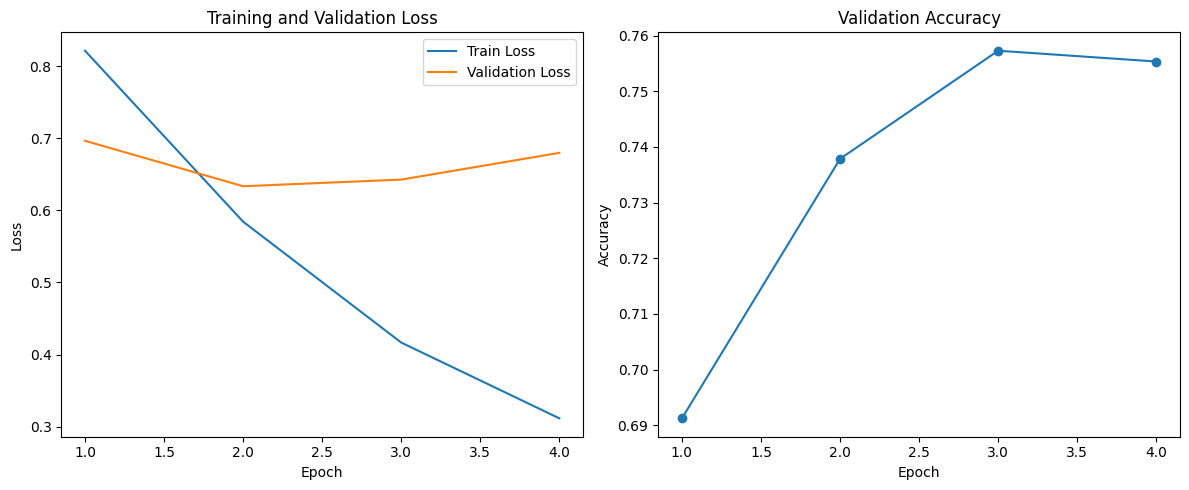

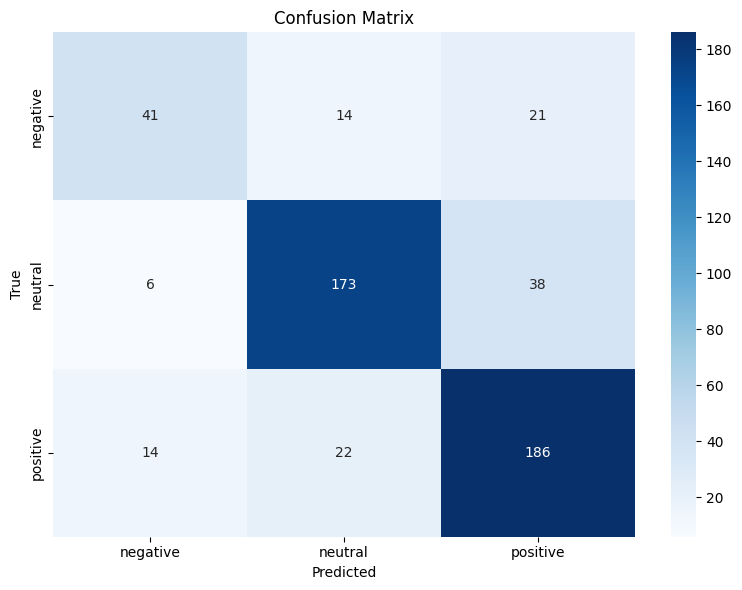

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # Import AdamW from torch.optim instead of transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import random
import sys

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create a dataset class
class FinancialSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def check_dataset_files():
    """Check if the required dataset files exist"""
    required_files = [
        'finbert_train_data.csv',
        'finbert_val_data.csv',
        'finbert_test_data.csv'
    ]

    missing_files = []
    for file in required_files:
        if not os.path.exists(file):
            missing_files.append(file)

    if missing_files:
        print("Error: The following required files are missing:")
        for file in missing_files:
            print(f"  - {file}")
        print("\nPlease run the dataset preparation script first.")
        return False

    return True

def load_data():
    """Load train, validation and test data"""
    print("Loading datasets...")

    try:
        # Check if files exist
        if not check_dataset_files():
            return None, None, None

        # Load datasets
        train_df = pd.read_csv('/content/finbert_train_data.csv')
        val_df = pd.read_csv('/content/finbert_val_data.csv')
        test_df = pd.read_csv('/content/finbert_test_data.csv')

        print(f"Loaded datasets: Train={len(train_df)}, Validation={len(val_df)}, Test={len(test_df)}")

        # Print column names to verify structure
        print(f"Train dataset columns: {train_df.columns.tolist()}")

        # Use cleaned text if available, otherwise use original text
        if 'cleaned_text' in train_df.columns:
            text_col = 'cleaned_text'
        else:
            text_col = 'text'

        print(f"Using '{text_col}' column for text data")

        # Check if sentiment column exists
        if 'sentiment' not in train_df.columns:
            print("Error: 'sentiment' column not found in datasets")
            return None, None, None

        # Print unique sentiment values
        print(f"Unique sentiment values in training data: {train_df['sentiment'].unique()}")

        # Convert sentiment labels to numeric
        sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}

        # Extract text and labels, handling errors gracefully
        train_texts = train_df[text_col].fillna("").tolist()
        train_labels = []
        for s in train_df['sentiment']:
            if s in sentiment_map:
                train_labels.append(sentiment_map[s])
            else:
                # Default to neutral for unknown values
                print(f"Warning: Unknown sentiment value '{s}', mapping to neutral")
                train_labels.append(1)

        val_texts = val_df[text_col].fillna("").tolist()
        val_labels = []
        for s in val_df['sentiment']:
            if s in sentiment_map:
                val_labels.append(sentiment_map[s])
            else:
                val_labels.append(1)

        test_texts = test_df[text_col].fillna("").tolist()
        test_labels = []
        for s in test_df['sentiment']:
            if s in sentiment_map:
                test_labels.append(sentiment_map[s])
            else:
                test_labels.append(1)

        # Verify data lengths match
        if len(train_texts) != len(train_labels):
            print(f"Error: Mismatch in train data: {len(train_texts)} texts vs {len(train_labels)} labels")
            return None, None, None

        if len(val_texts) != len(val_labels):
            print(f"Error: Mismatch in validation data: {len(val_texts)} texts vs {len(val_labels)} labels")
            return None, None, None

        if len(test_texts) != len(test_labels):
            print(f"Error: Mismatch in test data: {len(test_texts)} texts vs {len(test_labels)} labels")
            return None, None, None

        # Print class distribution
        print("Class distribution:")
        print(f"Train: {pd.Series(train_labels).value_counts().sort_index().to_dict()}")
        print(f"Validation: {pd.Series(val_labels).value_counts().sort_index().to_dict()}")
        print(f"Test: {pd.Series(test_labels).value_counts().sort_index().to_dict()}")

        return (train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels)

    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None, None, None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None, None

def train_model(train_data, val_data, tokenizer, model, epochs=4, batch_size=16, learning_rate=2e-5):
    """Train the FinBERT model"""
    train_texts, train_labels = train_data
    val_texts, val_labels = val_data

    # Adjust batch size based on device
    if device.type == 'cpu':
        print("Running on CPU. Reducing batch size to 8.")
        batch_size = min(batch_size, 8)

    # Create datasets
    try:
        print("Creating datasets...")
        train_dataset = FinancialSentimentDataset(train_texts, train_labels, tokenizer)
        val_dataset = FinancialSentimentDataset(val_texts, val_labels, tokenizer)

        # Create data loaders
        print("Creating data loaders...")
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Prepare optimizer and scheduler
        print("Setting up optimizer and scheduler...")
        optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

        # Total number of training steps
        total_steps = len(train_loader) * epochs

        # Set up learning rate scheduler
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # Initialize tracking variables
        best_val_accuracy = 0
        training_stats = []

        # Train the model
        print(f"Starting training with {epochs} epochs...")

        for epoch in range(epochs):
            print(f"{'='*20} Epoch {epoch+1}/{epochs} {'='*20}")

            # Training mode
            model.train()
            running_loss = 0

            # Progress bar for training
            progress_bar = tqdm(train_loader, desc=f"Training")

            for batch in progress_bar:
                try:
                    # Move batch to device
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    token_type_ids = batch['token_type_ids'].to(device)
                    labels = batch['label'].to(device)

                    # Reset gradients
                    model.zero_grad()

                    # Forward pass
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels
                    )

                    loss = outputs.loss
                    running_loss += loss.item()

                    # Backward pass
                    loss.backward()

                    # Clip gradients to prevent exploding gradients
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                    # Update weights
                    optimizer.step()

                    # Update scheduler
                    scheduler.step()

                    # Update progress bar
                    progress_bar.set_postfix({'loss': loss.item()})

                except Exception as e:
                    print(f"Error in training batch: {str(e)}")
                    continue

            # Calculate average training loss
            avg_train_loss = running_loss / len(train_loader)

            # Evaluation mode
            model.eval()
            val_losses = []
            val_preds = []
            val_true_labels = []

            # No gradient calculation for validation
            with torch.no_grad():
                # Progress bar for validation
                progress_bar = tqdm(val_loader, desc=f"Validation")

                for batch in progress_bar:
                    try:
                        # Move batch to device
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        token_type_ids = batch['token_type_ids'].to(device)
                        labels = batch['label'].to(device)

                        # Forward pass
                        outputs = model(
                            input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            labels=labels
                        )

                        loss = outputs.loss
                        val_losses.append(loss.item())

                        # Get predictions
                        logits = outputs.logits
                        preds = torch.argmax(logits, dim=1).cpu().numpy()
                        val_preds.extend(preds)

                        # Get true labels
                        true_labels = labels.cpu().numpy()
                        val_true_labels.extend(true_labels)

                    except Exception as e:
                        print(f"Error in validation batch: {str(e)}")
                        continue

            # Calculate validation metrics
            if val_preds and val_true_labels:
                val_accuracy = accuracy_score(val_true_labels, val_preds)
                val_loss = sum(val_losses) / max(len(val_losses), 1)  # Avoid division by zero
            else:
                val_accuracy = 0
                val_loss = float('inf')

            # Print epoch results
            print(f"Epoch {epoch+1}/{epochs} complete.")
            print(f"Train Loss: {avg_train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")
            print(f"Validation Accuracy: {val_accuracy:.4f}")

            # Save statistics
            training_stats.append({
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy
            })

            # Save best model
            if val_accuracy > best_val_accuracy:
                print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}. Saving model...")
                best_val_accuracy = val_accuracy

                # Save model
                model_path = 'finbert_best_model'
                if not os.path.exists(model_path):
                    os.makedirs(model_path)

                try:
                    model.save_pretrained(model_path)
                    tokenizer.save_pretrained(model_path)
                    print(f"Model saved to {model_path}")
                except Exception as e:
                    print(f"Error saving model: {str(e)}")

        # Plot training stats
        try:
            stats_df = pd.DataFrame(training_stats)
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.plot(stats_df['epoch'], stats_df['train_loss'], label='Train Loss')
            plt.plot(stats_df['epoch'], stats_df['val_loss'], label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(stats_df['epoch'], stats_df['val_accuracy'], 'o-')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Validation Accuracy')

            plt.tight_layout()
            plt.savefig('training_metrics.png')
            print("Saved training metrics to 'training_metrics.png'")
        except Exception as e:
            print(f"Error plotting training stats: {str(e)}")

        return model, best_val_accuracy, training_stats

    except Exception as e:
        print(f"Error in training process: {str(e)}")
        return model, 0, []

def evaluate_model(test_data, tokenizer, model):
    """Evaluate model on test data"""
    if test_data is None:
        print("Error: No test data provided for evaluation")
        return 0, None

    test_texts, test_labels = test_data

    try:
        # Create test dataset and dataloader
        test_dataset = FinancialSentimentDataset(test_texts, test_labels, tokenizer)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        # Evaluation mode
        model.eval()
        test_preds = []
        test_true_labels = []

        # No gradient calculation for testing
        with torch.no_grad():
            progress_bar = tqdm(test_loader, desc="Testing")

            for batch in progress_bar:
                try:
                    # Move batch to device
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    token_type_ids = batch['token_type_ids'].to(device)
                    labels = batch['label'].to(device)

                    # Forward pass
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids
                    )

                    # Get predictions
                    logits = outputs.logits
                    preds = torch.argmax(logits, dim=1).cpu().numpy()
                    test_preds.extend(preds)

                    # Get true labels
                    true_labels = labels.cpu().numpy()
                    test_true_labels.extend(true_labels)

                except Exception as e:
                    print(f"Error in test batch: {str(e)}")
                    continue

        # Calculate and print metrics if we have predictions
        if test_preds and test_true_labels:
            accuracy = accuracy_score(test_true_labels, test_preds)

            # Try to generate classification report
            try:
                report = classification_report(
                    test_true_labels,
                    test_preds,
                    target_names=['negative', 'neutral', 'positive'],
                    digits=4
                )
            except Exception as e:
                print(f"Error generating classification report: {str(e)}")
                report = "Classification report unavailable"

            print("\n===== Model Evaluation =====")
            print(f"Test Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(report)

            # Try to generate confusion matrix
            try:
                cm = confusion_matrix(test_true_labels, test_preds)

                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['negative', 'neutral', 'positive'],
                            yticklabels=['negative', 'neutral', 'positive'])
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.title('Confusion Matrix')
                plt.tight_layout()
                plt.savefig('confusion_matrix.png')
                print("Saved confusion matrix to 'confusion_matrix.png'")
            except Exception as e:
                print(f"Error generating confusion matrix: {str(e)}")

            return accuracy, report
        else:
            print("No predictions generated. Evaluation failed.")
            return 0, None

    except Exception as e:
        print(f"Error in model evaluation: {str(e)}")
        return 0, None

def test_model_inference(model, tokenizer, example_texts):
    """Test the model on a few example texts"""
    print("\n===== Testing Model Inference =====")
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}

    # Set model to evaluation mode
    model.eval()

    for text in example_texts:
        try:
            # Tokenize
            inputs = tokenizer(
                text,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=128
            ).to(device)

            # Predict
            with torch.no_grad():
                outputs = model(**inputs)

            # Get prediction
            logits = outputs.logits
            pred = torch.argmax(logits, dim=1).item()
            sentiment = label_map[pred]

            # Get confidence scores
            probs = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()

            print(f"\nText: {text}")
            print(f"Predicted sentiment: {sentiment}")
            print(f"Confidence scores: negative={probs[0]:.4f}, neutral={probs[1]:.4f}, positive={probs[2]:.4f}")

        except Exception as e:
            print(f"Error processing example text: {str(e)}")
            continue

def main():
    try:
        # Initialize BERT model and tokenizer
        model_name = 'bert-base-uncased'  # We'll fine-tune from base BERT

        print(f"Initializing model: {model_name}")

        try:
            tokenizer = BertTokenizer.from_pretrained(model_name)
            model = BertForSequenceClassification.from_pretrained(
                model_name,
                num_labels=3  # negative, neutral, positive
            )
            model.to(device)
        except Exception as e:
            print(f"Error initializing model: {str(e)}")
            return

        # Load datasets
        train_data, val_data, test_data = load_data()

        if train_data is None or val_data is None or test_data is None:
            print("Error loading datasets. Exiting.")
            return

        # Check dataset sizes
        if len(train_data[0]) == 0 or len(val_data[0]) == 0 or len(test_data[0]) == 0:
            print("Error: One or more datasets are empty. Exiting.")
            return

        # Train model
        trained_model, best_accuracy, stats = train_model(
            train_data,
            val_data,
            tokenizer,
            model,
            epochs=4,  # You can adjust this
            batch_size=16,  # You can adjust based on GPU memory
            learning_rate=2e-5
        )

        # Evaluate model
        evaluate_model(test_data, tokenizer, trained_model)

        # Test model on example texts
        example_texts = [
            "The company reported strong earnings, beating analyst expectations.",
            "The stock price has been falling steadily over the past week.",
            "The market remained largely unchanged today with minimal fluctuations.",
            "The company announced layoffs, causing investor concerns.",
            "The new product launch is expected to boost quarterly revenues."
        ]

        test_model_inference(trained_model, tokenizer, example_texts)

        print("\nFinBERT model training and evaluation complete!")

    except Exception as e:
        print(f"Unexpected error: {str(e)}")

if __name__ == "__main__":
    main()

Using device: cuda
Initializing model: ProsusAI/finbert
Model config labels: {0: 'positive', 1: 'negative', 2: 'neutral'}
Loading datasets...
Loaded datasets: Train=2402, Validation=515, Test=515
Train dataset columns: ['text', 'sentiment', 'source', 'cleaned_text']
Using 'cleaned_text' column for text data
Class distribution (in ProsusAI format - 0:positive, 1:negative, 2:neutral):
Train: {0: 1037, 1: 352, 2: 1013}
Validation: {0: 222, 1: 75, 2: 218}
Test: {0: 222, 1: 76, 2: 217}

Sample training data:
Text: rt iphone xr breakthrough camera system with depth control advanced face id a12 bionic the smartest ... Label: 1
Text: 06092018... Label: 2
Text: at hermès a 67 lipstick could hint at big ambitions... Label: 0
Text: india’s aviation regulator asks an airline to ground one unmodified airbus a320neo for every new add... Label: 0
Text: tlt tbt uso interest rates and oil carve out new lows as stocks slip... Label: 1
Creating datasets...
Creating data loaders...
Setting up optimizer an

Training:   0%|          | 0/151 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/4 complete.
Train Loss: 0.7655
Validation Loss: 0.5740
Validation Accuracy: 0.7631
Validation accuracy improved from 0.0000 to 0.7631. Saving model...
Model saved to finbert_best_model
==================== Epoch 2/4 ====================


Training:   0%|          | 0/151 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/4 complete.
Train Loss: 0.4732
Validation Loss: 0.5528
Validation Accuracy: 0.7825
Validation accuracy improved from 0.7631 to 0.7825. Saving model...
Model saved to finbert_best_model
==================== Epoch 3/4 ====================


Training:   0%|          | 0/151 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/4 complete.
Train Loss: 0.3071
Validation Loss: 0.6284
Validation Accuracy: 0.7961
Validation accuracy improved from 0.7825 to 0.7961. Saving model...
Model saved to finbert_best_model
==================== Epoch 4/4 ====================


Training:   0%|          | 0/151 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/4 complete.
Train Loss: 0.2047
Validation Loss: 0.6328
Validation Accuracy: 0.7942
Saved training metrics to 'training_metrics.png'


Testing:   0%|          | 0/33 [00:00<?, ?it/s]


===== Model Evaluation =====
Test Accuracy: 0.7534

Classification Report:
              precision    recall  f1-score   support

    positive     0.7510    0.8153    0.7819       222
    negative     0.5806    0.4737    0.5217        76
     neutral     0.8066    0.7880    0.7972       217

    accuracy                         0.7534       515
   macro avg     0.7128    0.6923    0.7003       515
weighted avg     0.7493    0.7534    0.7499       515

Saved confusion matrix to 'confusion_matrix.png'

===== Testing Model Inference =====

Text: The company reported strong earnings, beating analyst expectations.
Predicted sentiment: positive
Confidence scores: positive=0.9541, negative=0.0052, neutral=0.0407

Text: The stock price has been falling steadily over the past week.
Predicted sentiment: neutral
Confidence scores: positive=0.0071, negative=0.1217, neutral=0.8712

Text: The market remained largely unchanged today with minimal fluctuations.
Predicted sentiment: neutral
Confidence 

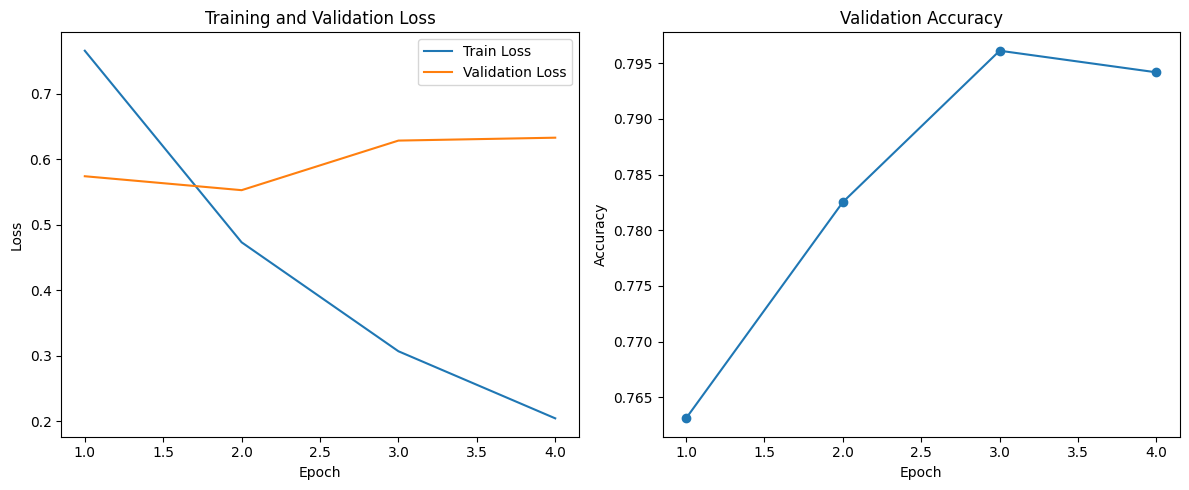

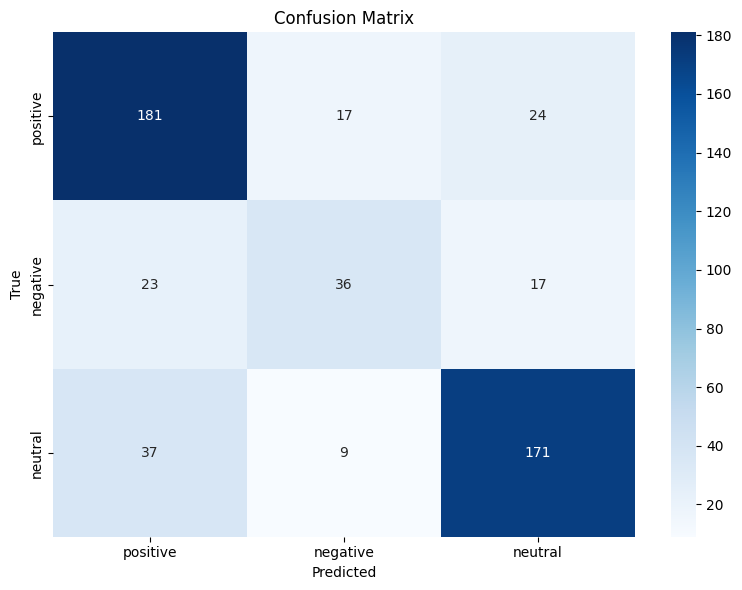

In [10]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import random
import sys

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create a dataset class
class FinancialSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def check_dataset_files():
    """Check if the required dataset files exist"""
    required_files = [
        'finbert_train_data.csv',
        'finbert_val_data.csv',
        'finbert_test_data.csv'
    ]

    missing_files = []
    for file in required_files:
        if not os.path.exists(file):
            missing_files.append(file)

    if missing_files:
        print("Error: The following required files are missing:")
        for file in missing_files:
            print(f"  - {file}")
        print("\nPlease run the dataset preparation script first.")
        return False

    return True

def load_data():
    """Load train, validation and test data"""
    print("Loading datasets...")

    try:
        if not check_dataset_files():
            return None, None, None

        train_df = pd.read_csv('/content/finbert_train_data.csv')
        val_df = pd.read_csv('/content/finbert_val_data.csv')
        test_df = pd.read_csv('/content/finbert_test_data.csv')

        print(f"Loaded datasets: Train={len(train_df)}, Validation={len(val_df)}, Test={len(test_df)}")
        print(f"Train dataset columns: {train_df.columns.tolist()}")

        text_col = 'cleaned_text' if 'cleaned_text' in train_df.columns else 'text'
        print(f"Using '{text_col}' column for text data")

        if 'sentiment' not in train_df.columns:
            print("Error: 'sentiment' column not found in datasets")
            return None, None, None

        # Updated sentiment mapping to match ProsusAI/finbert
        # The model expects: 0=positive, 1=negative, 2=neutral
        sentiment_map = {
            'positive': 0,  # Maps to ProsusAI's positive (0)
            'negative': 1,  # Maps to ProsusAI's negative (1)
            'neutral': 2    # Maps to ProsusAI's neutral (2)
        }

        def map_sentiment(s):
            if pd.isna(s):
                return 2  # Default to neutral if missing
            if isinstance(s, str):
                s = s.lower()
                if s not in sentiment_map:
                    print(f"Warning: Unknown sentiment '{s}', mapping to neutral")
                    return 2
                return sentiment_map[s]
            else:
                # Handle numeric labels
                try:
                    s = int(s)
                    # If your data uses: 0=negative, 1=neutral, 2=positive
                    # Convert to ProsusAI format: 0=positive, 1=negative, 2=neutral
                    if s == 0:  # negative
                        return 1
                    elif s == 1:  # neutral
                        return 2
                    elif s == 2:  # positive
                        return 0
                    else:
                        print(f"Warning: Invalid sentiment value {s}, mapping to neutral")
                        return 2
                except:
                    print(f"Warning: Invalid sentiment type {type(s)}, mapping to neutral")
                    return 2

        train_labels = [map_sentiment(s) for s in train_df['sentiment']]
        val_labels = [map_sentiment(s) for s in val_df['sentiment']]
        test_labels = [map_sentiment(s) for s in test_df['sentiment']]

        train_texts = train_df[text_col].fillna("").tolist()
        val_texts = val_df[text_col].fillna("").tolist()
        test_texts = test_df[text_col].fillna("").tolist()

        if len(train_texts) != len(train_labels):
            print(f"Error: Mismatch in train data: {len(train_texts)} texts vs {len(train_labels)} labels")
            return None, None, None
        if len(val_texts) != len(val_labels):
            print(f"Error: Mismatch in validation data: {len(val_texts)} texts vs {len(val_labels)} labels")
            return None, None, None
        if len(test_texts) != len(test_labels):
            print(f"Error: Mismatch in test data: {len(test_texts)} texts vs {len(test_labels)} labels")
            return None, None, None

        print("Class distribution (in ProsusAI format - 0:positive, 1:negative, 2:neutral):")
        print(f"Train: {pd.Series(train_labels).value_counts().sort_index().to_dict()}")
        print(f"Validation: {pd.Series(val_labels).value_counts().sort_index().to_dict()}")
        print(f"Test: {pd.Series(test_labels).value_counts().sort_index().to_dict()}")

        print("\nSample training data:")
        for i in range(min(5, len(train_texts))):
            print(f"Text: {train_texts[i][:100]}... Label: {train_labels[i]}")

        return (train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels)

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None, None

def train_model(train_data, val_data, tokenizer, model, epochs=4, batch_size=16, learning_rate=2e-5):
    """Train the FinBERT model"""
    train_texts, train_labels = train_data
    val_texts, val_labels = val_data

    if device.type == 'cpu':
        print("Running on CPU. Reducing batch size to 8.")
        batch_size = min(batch_size, 8)

    try:
        print("Creating datasets...")
        train_dataset = FinancialSentimentDataset(train_texts, train_labels, tokenizer)
        val_dataset = FinancialSentimentDataset(val_texts, val_labels, tokenizer)

        print("Creating data loaders...")
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        print("Setting up optimizer and scheduler...")
        optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        best_val_accuracy = 0
        training_stats = []

        print(f"Starting training with {epochs} epochs...")
        for epoch in range(epochs):
            print(f"{'='*20} Epoch {epoch+1}/{epochs} {'='*20}")
            model.train()
            running_loss = 0
            progress_bar = tqdm(train_loader, desc="Training")
            for batch in progress_bar:
                try:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    token_type_ids = batch['token_type_ids'].to(device)
                    labels = batch['label'].to(device)

                    model.zero_grad()
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
                    loss = outputs.loss
                    running_loss += loss.item()

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    scheduler.step()
                    progress_bar.set_postfix({'loss': loss.item()})
                except Exception as e:
                    print(f"Error in training batch: {str(e)}")
                    continue

            avg_train_loss = running_loss / len(train_loader)

            model.eval()
            val_losses = []
            val_preds = []
            val_true_labels = []
            with torch.no_grad():
                progress_bar = tqdm(val_loader, desc="Validation")
                for batch in progress_bar:
                    try:
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        token_type_ids = batch['token_type_ids'].to(device)
                        labels = batch['label'].to(device)

                        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
                        loss = outputs.loss
                        val_losses.append(loss.item())
                        logits = outputs.logits
                        preds = torch.argmax(logits, dim=1).cpu().numpy()
                        val_preds.extend(preds)
                        val_true_labels.extend(labels.cpu().numpy())
                    except Exception as e:
                        print(f"Error in validation batch: {str(e)}")
                        continue

            val_accuracy = accuracy_score(val_true_labels, val_preds) if val_preds else 0
            val_loss = sum(val_losses) / len(val_losses) if val_losses else float('inf')

            print(f"Epoch {epoch+1}/{epochs} complete.")
            print(f"Train Loss: {avg_train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")
            print(f"Validation Accuracy: {val_accuracy:.4f}")

            training_stats.append({'epoch': epoch + 1, 'train_loss': avg_train_loss, 'val_loss': val_loss, 'val_accuracy': val_accuracy})

            if val_accuracy > best_val_accuracy:
                print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}. Saving model...")
                best_val_accuracy = val_accuracy
                model_path = 'finbert_best_model'
                if not os.path.exists(model_path):
                    os.makedirs(model_path)
                try:
                    model.save_pretrained(model_path)
                    tokenizer.save_pretrained(model_path)
                    print(f"Model saved to {model_path}")
                except Exception as e:
                    print(f"Error saving model: {str(e)}")

        try:
            stats_df = pd.DataFrame(training_stats)
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(stats_df['epoch'], stats_df['train_loss'], label='Train Loss')
            plt.plot(stats_df['epoch'], stats_df['val_loss'], label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.plot(stats_df['epoch'], stats_df['val_accuracy'], 'o-')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Validation Accuracy')
            plt.tight_layout()
            plt.savefig('training_metrics.png')
            print("Saved training metrics to 'training_metrics.png'")
        except Exception as e:
            print(f"Error plotting training stats: {str(e)}")

        return model, best_val_accuracy, training_stats

    except Exception as e:
        print(f"Error in training process: {str(e)}")
        return model, 0, []

def evaluate_model(test_data, tokenizer, model):
    """Evaluate model on test data"""
    if test_data is None:
        print("Error: No test data provided for evaluation")
        return 0, None

    test_texts, test_labels = test_data
    try:
        test_dataset = FinancialSentimentDataset(test_texts, test_labels, tokenizer)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        model.eval()
        test_preds = []
        test_true_labels = []
        with torch.no_grad():
            progress_bar = tqdm(test_loader, desc="Testing")
            for batch in progress_bar:
                try:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    token_type_ids = batch['token_type_ids'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                    logits = outputs.logits
                    preds = torch.argmax(logits, dim=1).cpu().numpy()
                    test_preds.extend(preds)
                    test_true_labels.extend(labels.cpu().numpy())
                except Exception as e:
                    print(f"Error in test batch: {str(e)}")
                    continue

        if test_preds and test_true_labels:
            accuracy = accuracy_score(test_true_labels, test_preds)
            try:
                # Update target names to match ProsusAI format
                report = classification_report(test_true_labels, test_preds,
                                           target_names=['positive', 'negative', 'neutral'],
                                           digits=4)
            except Exception as e:
                print(f"Error generating classification report: {str(e)}")
                report = "Classification report unavailable"

            print("\n===== Model Evaluation =====")
            print(f"Test Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(report)

            try:
                cm = confusion_matrix(test_true_labels, test_preds)
                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['positive', 'negative', 'neutral'],
                            yticklabels=['positive', 'negative', 'neutral'])
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.title('Confusion Matrix')
                plt.tight_layout()
                plt.savefig('confusion_matrix.png')
                print("Saved confusion matrix to 'confusion_matrix.png'")
            except Exception as e:
                print(f"Error generating confusion matrix: {str(e)}")

            return accuracy, report
        else:
            print("No predictions generated. Evaluation failed.")
            return 0, None

    except Exception as e:
        print(f"Error in model evaluation: {str(e)}")
        return 0, None

def test_model_inference(model, tokenizer, example_texts):
    """Test the model on a few example texts"""
    print("\n===== Testing Model Inference =====")
    # Update label map to match ProsusAI format
    label_map = {0: 'positive', 1: 'negative', 2: 'neutral'}
    model.eval()

    for text in example_texts:
        try:
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
            logits = outputs.logits
            pred = torch.argmax(logits, dim=1).item()
            sentiment = label_map[pred]
            probs = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()

            print(f"\nText: {text}")
            print(f"Predicted sentiment: {sentiment}")
            print(f"Confidence scores: positive={probs[0]:.4f}, negative={probs[1]:.4f}, neutral={probs[2]:.4f}")
        except Exception as e:
            print(f"Error processing example text: {str(e)}")
            continue

def main():
    try:
        # Use ProsusAI/finbert model
        model_name = 'ProsusAI/finbert'
        print(f"Initializing model: {model_name}")
        try:
            # Use AutoModel to automatically load the correct model configuration
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = AutoModelForSequenceClassification.from_pretrained(model_name)
            model.to(device)

            # Get the model config to check label mapping
            config = model.config
            print(f"Model config labels: {getattr(config, 'id2label', 'Not found')}")

        except Exception as e:
            print(f"Error initializing model: {str(e)}")
            return

        train_data, val_data, test_data = load_data()
        if train_data is None or val_data is None or test_data is None:
            print("Error loading datasets. Exiting.")
            return

        if len(train_data[0]) == 0 or len(val_data[0]) == 0 or len(test_data[0]) == 0:
            print("Error: One or more datasets are empty. Exiting.")
            return

        trained_model, best_accuracy, stats = train_model(train_data, val_data, tokenizer, model, epochs=4, batch_size=16, learning_rate=2e-5)
        evaluate_model(test_data, tokenizer, trained_model)

        example_texts = [
            "The company reported strong earnings, beating analyst expectations.",
            "The stock price has been falling steadily over the past week.",
            "The market remained largely unchanged today with minimal fluctuations.",
            "The company announced layoffs, causing investor concerns.",
            "The new product launch is expected to boost quarterly revenues."
        ]
        test_model_inference(trained_model, tokenizer, example_texts)

        print("\nFinBERT model training and evaluation complete!")
    except Exception as e:
        print(f"Unexpected error: {str(e)}")

if __name__ == "__main__":
    main()

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
import os
from tqdm import tqdm
import logging
import datetime
import re
import string
import warnings
from datetime import timedelta
import traceback
warnings.filterwarnings('ignore')

# Configuration settings
CONFIG = {
    "model_path": "/content/finbert_best_model",  # Path to fine-tuned model
    "ticker": "SPY",                      # Default stock ticker
    "start_date": "2023-01-01",           # Default start date
    "end_date": "2023-12-31",             # Default end date
    "initial_capital": 10000,             # Initial capital for trading
    "log_level": logging.INFO,            # Logging level
    "temperature": 1.2,                   # Temperature for softmax calibration
    "batch_size": 16,                     # Batch size for inference
    "random_seed": 42,                    # Random seed for reproducibility
    "sentiment_thresholds": {             # Sentiment classification thresholds
        "positive": 0.2,
        "negative": -0.2
    },
    "risk_management": {                  # Risk management parameters
        "stop_loss": 0.02,                # Stop loss percentage
        "take_profit": 0.05,              # Take profit percentage
        "max_position_size": 0.80,        # Maximum position size as % of capital
        "min_holding_period": 1,          # Minimum holding period in days
        "max_holding_period": 15          # Maximum holding period in days
    }
}

# Configure logging
logging.basicConfig(
    level=CONFIG["log_level"],
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f"finbert_trading_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set seeds for reproducibility
def set_seed(seed=CONFIG["random_seed"]):
    """Set seeds for reproducibility"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# PART 1: TEXT PREPROCESSING AND SENTIMENT ANALYSIS

def preprocess_text(text):
    """Clean and preprocess text data for sentiment analysis"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove user mentions (Twitter @user)
    text = re.sub(r'@\w+', '', text)

    # Remove special characters but keep important punctuation for sentiment
    text = re.sub(r'[^\w\s\.\!\?\,\$\%]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def load_finbert_model(model_path=CONFIG["model_path"]):
    """Load the fine-tuned FinBERT model"""
    try:
        logger.info(f"Loading FinBERT model from {model_path}...")

        if os.path.exists(model_path):
            tokenizer = BertTokenizer.from_pretrained(model_path)
            model = BertForSequenceClassification.from_pretrained(model_path)
            model.to(device)
            logger.info("Successfully loaded fine-tuned FinBERT model")
        else:
            logger.warning(f"Model path {model_path} not found, loading pre-trained FinBERT model instead")
            tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
            model = BertForSequenceClassification.from_pretrained(
                'ProsusAI/finbert',
                num_labels=3
            )
            model.to(device)
            logger.info("Loaded pre-trained FinBERT model as fallback")

        return model, tokenizer

    except Exception as e:
        logger.error(f"Error loading FinBERT model: {str(e)}")
        logger.warning("Will use random sentiment scores for testing")
        return None, None

def analyze_sentiment(texts, model, tokenizer, temperature=CONFIG["temperature"]):
    """Analyze sentiment of financial texts using the fine-tuned FinBERT model"""
    logger.info("Analyzing sentiment with FinBERT model...")

    # Preprocess texts
    preprocessed_texts = [preprocess_text(text) for text in texts]

    if model is None or tokenizer is None:
        logger.warning("No model available, generating random sentiment scores")
        random_scores = [np.random.uniform(-0.8, 0.8) for _ in preprocessed_texts]
        random_labels = [0 if s < CONFIG["sentiment_thresholds"]["negative"]
                         else 2 if s > CONFIG["sentiment_thresholds"]["positive"]
                         else 1 for s in random_scores]
        random_sentiments = [["negative", "neutral", "positive"][l] for l in random_labels]

        return pd.DataFrame({
            'text': texts,
            'preprocessed_text': preprocessed_texts,
            'sentiment_score': random_scores,
            'sentiment_label': random_labels,
            'sentiment': random_sentiments,
            'confidence': [abs(s) for s in random_scores]
        })

    # Set model to evaluation mode
    model.eval()

    # Initialize result lists
    sentiment_scores = []
    sentiment_labels = []
    sentiment_confidences = []
    batch_size = CONFIG["batch_size"]

    # Process in batches
    for i in tqdm(range(0, len(preprocessed_texts), batch_size), desc="Sentiment Analysis"):
        batch_texts = preprocessed_texts[i:i+batch_size]
        try:
            # Tokenize
            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=256
            ).to(device)

            # Forward pass
            with torch.no_grad():
                outputs = model(**inputs)

            # Apply temperature scaling for better calibration
            logits = outputs.logits
            scaled_logits = logits / temperature

            # Get probabilities and predictions
            probs = F.softmax(scaled_logits, dim=1).cpu().numpy()

            # Process each prediction in batch
            for prob in probs:
                # Get prediction
                label = np.argmax(prob)

                # Calculate sentiment score from -1 to 1
                # Negative (0): -1, Neutral (1): 0, Positive (2): 1
                score = -1 * prob[0] + 1 * prob[2]

                # Get prediction confidence
                confidence = prob[label]

                sentiment_labels.append(label)
                sentiment_scores.append(score)
                sentiment_confidences.append(confidence)

        except Exception as e:
            logger.error(f"Error analyzing batch: {str(e)}")
            logger.error(traceback.format_exc())
            # Fill with neutral values on error
            for _ in batch_texts:
                sentiment_labels.append(1)
                sentiment_scores.append(0)
                sentiment_confidences.append(0.33)

    # Map labels to sentiment categories
    sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
    sentiment_categories = [sentiment_map[label] for label in sentiment_labels]

    # Create DataFrame with results
    results = pd.DataFrame({
        'text': texts,
        'preprocessed_text': preprocessed_texts,
        'sentiment_score': sentiment_scores,
        'sentiment_label': sentiment_labels,
        'sentiment': sentiment_categories,
        'confidence': sentiment_confidences
    })

    # Display distribution
    logger.info("\nSentiment Distribution:")
    sentiment_counts = results['sentiment'].value_counts()
    logger.info(sentiment_counts)

    # Save predictions to CSV
    results.to_csv('sentiment_predictions.csv', index=False)
    logger.info("Sentiment predictions saved to 'sentiment_predictions.csv'")

    return results

def generate_financial_news(ticker, dates, num_samples=None):
    """Generate simulated financial news for a given ticker and dates"""
    logger.info(f"Generating simulated financial news for {ticker}...")

    if num_samples is not None and num_samples < len(dates):
        # Randomly sample dates if we need fewer than available
        date_indices = np.random.choice(range(len(dates)), size=num_samples, replace=False)
        dates = [dates[i] for i in date_indices]

    headlines = []
    for date in dates:
        day = date.day
        month = date.month
        weekday = date.weekday()  # Monday is 0, Sunday is 6

        # Base templates
        positive_templates = [
            f"{ticker} reports strong quarterly results, exceeding analyst expectations",
            f"Analysts upgrade {ticker} citing growth potential and market expansion",
            f"{ticker} announces new product launch, shares rally on positive outlook",
            f"{ticker} beats earnings forecasts, raises guidance for coming quarter",
            f"Investor confidence grows in {ticker} following strategic acquisition",
            f"{ticker} shares surge on positive economic data and sector outperformance"
        ]

        negative_templates = [
            f"{ticker} faces challenges as competition intensifies in the market",
            f"Earnings report disappoints for {ticker}, shares decline on revenue miss",
            f"Regulatory concerns weigh on {ticker} as investigation announced",
            f"{ticker} cuts forecast, cites supply chain issues and inflationary pressures",
            f"Analysts downgrade {ticker} amid concerns over market saturation",
            f"{ticker} shares drop on disappointing sales figures and margin pressure"
        ]

        neutral_templates = [
            f"{ticker} shares trade flat amid mixed market signals",
            f"Investors await quarterly results from {ticker} as market remains cautious",
            f"{ticker} maintains market position despite industry headwinds",
            f"Analysts have mixed outlook on {ticker} ahead of economic data release",
            f"{ticker} announces leadership transition, impact on strategy remains unclear",
            f"Trading volume increases for {ticker} as investors reassess market positioning"
        ]

        # Context phrases to add variety
        context_phrases = [
            " amid economic uncertainty",
            " as interest rates fluctuate",
            " with sector performance mixed",
            " as investors assess inflation impact",
            " following Federal Reserve commentary",
            " while broader market trends remain positive",
            " despite geopolitical tensions",
            " as competitors announce similar initiatives",
            " while ESG concerns affect industry sentiment",
            " with analysts divided on future performance"
        ]

        # Select template based on day of month pattern
        if day % 10 <= 3:  # First 3 days of each 10-day period tend positive
            template = np.random.choice(positive_templates)
        elif day % 10 >= 7:  # Last 3 days of each 10-day period tend negative
            template = np.random.choice(negative_templates)
        else:  # Middle days tend neutral
            template = np.random.choice(neutral_templates)

        # Add randomization based on weekday
        if weekday == 0:  # Monday - more negative
            if np.random.random() < 0.3 and template not in negative_templates:
                template = np.random.choice(negative_templates)
        elif weekday == 4:  # Friday - more positive
            if np.random.random() < 0.3 and template not in positive_templates:
                template = np.random.choice(positive_templates)

        # Add context phrase for variety
        context = np.random.choice(context_phrases)
        headline = template + context

        headlines.append(headline)

    return headlines

# PART 2: FINANCIAL DATA PROCESSING

def get_stock_data(ticker=CONFIG["ticker"], start_date=CONFIG["start_date"], end_date=CONFIG["end_date"]):
    """Download and preprocess stock data with technical indicators"""
    try:
        logger.info(f"Downloading data for {ticker} from {start_date} to {end_date}...")
        stock_data = yf.download(ticker, start=start_date, end=end_date)

        if stock_data.empty:
            raise ValueError(f"No data available for {ticker}")

        logger.info(f"Downloaded {len(stock_data)} days of data")

        # Reset index and ensure date is a column
        stock_data = stock_data.reset_index()
        stock_data.rename(columns={'Date': 'date'}, inplace=True)
        stock_data['date'] = pd.to_datetime(stock_data['date'])

        # Add technical indicators
        stock_data = add_technical_indicators(stock_data)

        return stock_data

    except Exception as e:
        logger.error(f"Error downloading stock data: {str(e)}")
        logger.error(traceback.format_exc())
        return create_synthetic_stock_data(start_date, end_date)

def create_synthetic_stock_data(start_date, end_date):
    """Create synthetic stock data for testing purposes"""
    logger.warning("Creating synthetic stock data for testing...")

    # Generate dates (business days)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    dates = []
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() < 5:  # Monday to Friday only
            dates.append(current_date)
        current_date += timedelta(days=1)

    # Generate a random walk with drift for prices
    np.random.seed(CONFIG["random_seed"])  # For reproducibility
    returns = np.random.normal(0.0005, 0.01, len(dates))  # Mean positive drift

    # Convert returns to price series
    price_index = 100 * (1 + returns).cumprod()

    # Create dataframe with OHLC data
    synthetic_data = pd.DataFrame({
        'date': dates,
        'Open': price_index * np.random.uniform(0.99, 0.995, len(dates)),
        'High': price_index * np.random.uniform(1.005, 1.015, len(dates)),
        'Low': price_index * np.random.uniform(0.985, 0.995, len(dates)),
        'Close': price_index,
        'Adj Close': price_index,
        'Volume': np.random.randint(500000, 5000000, len(dates))
    })

    # Add technical indicators
    synthetic_data = add_technical_indicators(synthetic_data)

    logger.info(f"Created synthetic data with {len(synthetic_data)} days")
    return synthetic_data

def add_technical_indicators(df):
    """Add comprehensive technical indicators to stock data"""
    logger.info("Adding technical indicators...")

    # Ensure we have price columns
    price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    df['price'] = df[price_col]

    # Basic returns
    df['daily_return'] = df['price'].pct_change()
    df['return_3d'] = df['price'].pct_change(periods=3)
    df['return_5d'] = df['price'].pct_change(periods=5)

    # Moving averages
    df['ma5'] = df['price'].rolling(window=5).mean()
    df['ma10'] = df['price'].rolling(window=10).mean()
    df['ma20'] = df['price'].rolling(window=20).mean()
    df['ma50'] = df['price'].rolling(window=50).mean()
    df['ma200'] = df['price'].rolling(window=200).mean()

    # Moving average crossovers
    df['ma5_10_cross'] = (df['ma5'] > df['ma10']).astype(int)
    df['ma10_20_cross'] = (df['ma10'] > df['ma20']).astype(int)
    df['ma20_50_cross'] = (df['ma20'] > df['ma50']).astype(int)
    df['ma50_200_cross'] = (df['ma50'] > df['ma200']).astype(int)  # Golden/Death cross

    # Volatility
    df['volatility_5d'] = df['daily_return'].rolling(window=5).std() * np.sqrt(252)
    df['volatility_20d'] = df['daily_return'].rolling(window=20).std() * np.sqrt(252)

    # RSI (Relative Strength Index)
    df['rsi14'] = calculate_rsi(df['price'], window=14)

    # MACD (Moving Average Convergence Divergence)
    df['ema12'] = df['price'].ewm(span=12, adjust=False).mean()
    df['ema26'] = df['price'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema12'] - df['ema26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    df['macd_cross'] = ((df['macd'] > df['macd_signal']).astype(int) -
                        (df['macd'] < df['macd_signal']).astype(int))

    # Bollinger Bands
    window = 20
    df['bb_middle'] = df['price'].rolling(window=window).mean()
    df['bb_std'] = df['price'].rolling(window=window).std()
    df['bb_upper'] = df['bb_middle'] + (df['bb_std'] * 2)
    df['bb_lower'] = df['bb_middle'] - (df['bb_std'] * 2)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']

    # Bollinger Band position (where is price relative to bands)
    df['bb_position'] = (df['price'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

    # Volume indicators (if volume data is available)
    if 'Volume' in df.columns:
        # Ensure Volume is a Series, not a DataFrame
        if isinstance(df['Volume'], pd.DataFrame):
            logger.warning("Volume column is a DataFrame, taking the first column")
            volume_data = df['Volume'].iloc[:, 0]
        else:
            volume_data = df['Volume']

        df['volume_ma20'] = volume_data.rolling(window=20).mean()
        df['volume_ratio'] = volume_data / df['volume_ma20']

        # On-Balance Volume (OBV)
        df['obv'] = (volume_data * ((df['price'].diff() > 0).astype(int) -
                                    (df['price'].diff() < 0).astype(int))).cumsum()

    # Price momentum
    df['momentum_10d'] = df['price'] / df['price'].shift(10) - 1

    # Average True Range (ATR) - Volatility indicator
    df['tr1'] = abs(df['High'] - df['Low'])
    df['tr2'] = abs(df['High'] - df['price'].shift())
    df['tr3'] = abs(df['Low'] - df['price'].shift())
    df['true_range'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)
    df['atr14'] = df['true_range'].rolling(window=14).mean()

    # 52-week (255 trading days) high and low
    df['52w_high'] = df['price'].rolling(window=255).max()
    df['52w_low'] = df['price'].rolling(window=255).min()
    df['52w_high_ratio'] = df['price'] / df['52w_high']
    df['52w_low_ratio'] = df['price'] / df['52w_low']

    # Clean up NaN values
    for col in df.columns:
        if df[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
            # Different filling strategies based on column type
            if col.startswith(('return', 'momentum', 'macd')):
                df[col] = df[col].fillna(0)
            elif col.startswith(('ma', 'ema', 'bb')):
                df[col] = df[col].fillna(method='bfill')
            elif col.startswith(('volatility', 'rsi', 'atr')):
                df[col] = df[col].fillna(df[col].median())

    # Drop any remaining rows with NaN values
    original_len = len(df)
    df = df.dropna()
    if len(df) < original_len:
        logger.warning(f"Dropped {original_len - len(df)} rows with NaN values")

    return df

def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index."""
    # Calculate price changes
    delta = prices.diff()

    # Get positive and negative price changes
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Calculate initial average gain and loss
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    # Handle division by zero
    avg_loss_nonzero = avg_loss.replace(0, np.finfo(float).eps)

    # Calculate RS and RSI
    rs = avg_gain / avg_loss_nonzero
    rsi = 100 - (100 / (1 + rs))

    return rsi

def combine_financial_and_sentiment_data(financial_df, sentiment_df, date_align_method='distribute'):
    """Combine financial data with sentiment analysis results"""
    logger.info("Combining financial data with sentiment analysis...")

    # Create a copy of the dataframes
    financial_df = financial_df.copy()
    sentiment_df = sentiment_df.copy() if sentiment_df is not None else None

    # If no sentiment data provided, generate simulated news and analyze sentiment
    if sentiment_df is None or len(sentiment_df) == 0:
        logger.info("No sentiment data provided, generating simulated news...")

        # Generate simulated financial news
        dates = financial_df['date'].tolist()
        news_texts = generate_financial_news(CONFIG["ticker"], dates)

        # Load model and analyze sentiment
        model, tokenizer = load_finbert_model()
        sentiment_df = analyze_sentiment(news_texts, model, tokenizer)

        # Add dates to sentiment data
        sentiment_df['date'] = dates

    # Ensure date columns are datetime
    financial_df['date'] = pd.to_datetime(financial_df['date'])

    # Align sentiment data with financial dates if needed
    if 'date' not in sentiment_df.columns:
        logger.info(f"Using {date_align_method} method to align sentiment with financial dates")

        if date_align_method == 'distribute':
            # Distribute sentiment data across available dates
            date_samples = financial_df['date'].sample(
                n=len(sentiment_df),
                replace=len(sentiment_df) > len(financial_df),
                random_state=CONFIG["random_seed"]
            )
            # Sort dates to maintain chronological order
            sentiment_df['date'] = sorted(date_samples.values)

        elif date_align_method == 'sequential':
            # Assign sentiment sequentially from the start date
            start_idx = financial_df['date'].idxmin()
            dates = []
            for i in range(len(sentiment_df)):
                if start_idx + i < len(financial_df):
                    dates.append(financial_df.loc[start_idx + i, 'date'])
                else:
                    # If we run out of financial dates, repeat the last date
                    dates.append(dates[-1])
            sentiment_df['date'] = dates
    else:
        # Ensure the date column is in datetime format
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

    # Select columns for the merge
    sentiment_cols = ['date', 'text', 'sentiment_score', 'sentiment', 'confidence']
    available_cols = [col for col in sentiment_cols if col in sentiment_df.columns]

    # Merge datasets on date
    combined_df = pd.merge(
        financial_df,
        sentiment_df[available_cols],
        on='date',
        how='left'
    )

    # Handle missing sentiment data
    if combined_df['sentiment_score'].isna().any():
        logger.warning(f"{combined_df['sentiment_score'].isna().sum()} days have missing sentiment data. Filling with neutral values.")
        combined_df['sentiment_score'] = combined_df['sentiment_score'].fillna(0)

        if 'sentiment' in combined_df.columns:
            combined_df['sentiment'] = combined_df['sentiment'].fillna('neutral')

        if 'confidence' in combined_df.columns:
            combined_df['confidence'] = combined_df['confidence'].fillna(0.5)

    # Add sentiment rolling averages and indicators
    combined_df['sentiment_ma3'] = combined_df['sentiment_score'].rolling(window=3).mean()
    combined_df['sentiment_ma5'] = combined_df['sentiment_score'].rolling(window=5).mean()
    combined_df['sentiment_ma10'] = combined_df['sentiment_score'].rolling(window=10).mean()

    # Add sentiment momentum and oscillators
    combined_df['sentiment_momentum'] = combined_df['sentiment_ma5'] - combined_df['sentiment_ma10']
    combined_df['sentiment_roc'] = combined_df['sentiment_score'].pct_change(5)  # Rate of change

    # Fill NaN values in sentiment indicators
    for col in ['sentiment_ma3', 'sentiment_ma5', 'sentiment_ma10', 'sentiment_momentum', 'sentiment_roc']:
        combined_df[col] = combined_df[col].fillna(0)

    logger.info(f"Combined data has {len(combined_df)} rows")

    return combined_df

# PART 3: CORRELATION ANALYSIS AND STRATEGY DEVELOPMENT

def analyze_sentiment_market_correlations(df):
    """Analyze correlations between sentiment metrics and market movements"""
    logger.info("Analyzing correlations between sentiment and market metrics...")

    # Define metrics to analyze
    financial_metrics = [
        'daily_return', 'return_3d', 'return_5d',
        'volatility_5d', 'volatility_20d', 'rsi14'
    ]

    if 'volume_ratio' in df.columns:
        financial_metrics.append('volume_ratio')

    sentiment_metrics = [
        'sentiment_score', 'sentiment_ma3', 'sentiment_ma5',
        'sentiment_ma10', 'sentiment_momentum', 'sentiment_roc'
    ]

    # Calculate correlation matrix
    correlation_metrics = financial_metrics + sentiment_metrics
    correlation_matrix = df[correlation_metrics].corr()

    # Display sentiment correlations with financial metrics
    logger.info("\nCorrelation with financial metrics:")
    for s_metric in sentiment_metrics:
        correlations = []
        for f_metric in financial_metrics:
            corr = correlation_matrix.loc[s_metric, f_metric]
            correlations.append((f_metric, corr))

        # Sort by absolute correlation value
        correlations.sort(key=lambda x: abs(x[1]), reverse=True)

        logger.info(f"\n{s_metric}:")
        for f_metric, corr in correlations:
            logger.info(f"  {f_metric}: {corr:.4f}")

    # Lag analysis - Does sentiment predict future returns?
    logger.info("\nLag correlation analysis (sentiment → future returns):")

    lag_results = {}

    # Test different lags (1-10 days forward)
    for lag in range(1, 11):
        future_col = f'future_return_{lag}d'
        df[future_col] = df['daily_return'].shift(-lag)  # Future returns

        for s_metric in sentiment_metrics:
            key = f"{s_metric} → {future_col}"
            valid_data = df.dropna(subset=[future_col, s_metric])

            if len(valid_data) > 5:
                # Calculate both Pearson and Spearman correlations
                pearson_corr = valid_data[s_metric].corr(valid_data[future_col], method='pearson')
                spearman_corr = valid_data[s_metric].corr(valid_data[future_col], method='spearman')

                lag_results[key] = {
                    'pearson': pearson_corr,
                    'spearman': spearman_corr,
                    'lag': lag,
                    'sentiment_metric': s_metric
                }

    # Sort and display lag results
    sorted_lag_results = sorted(lag_results.items(), key=lambda x: abs(x[1]['pearson']), reverse=True)

    logger.info("\nTop sentiment → future return correlations (Pearson):")
    for key, values in sorted_lag_results[:7]:  # Show top 7
        logger.info(f"{key}: r={values['pearson']:.4f}, rho={values['spearman']:.4f}")

    # Find the best sentiment metric for predicting returns
    best_sentiment_metric = None
    best_lag = None
    best_corr = 0

    for key, values in sorted_lag_results:
        if abs(values['pearson']) > abs(best_corr):
            best_corr = values['pearson']
            best_sentiment_metric = values['sentiment_metric']
            best_lag = values['lag']

    logger.info(f"\nBest predictor: {best_sentiment_metric} for {best_lag}-day future returns (r={best_corr:.4f})")

    # Create visualizations
    try:
        os.makedirs('visualizations', exist_ok=True)

        # 1. Correlation Heatmap
        plt.figure(figsize=(14, 12))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
        plt.title('Correlation Between Sentiment and Financial Metrics')
        plt.tight_layout()
        plt.savefig('visualizations/correlation_heatmap.png')
        plt.close()

        # 2. Scatter plot of best sentiment-return pair
        if best_sentiment_metric and best_lag:
            future_col = f'future_return_{best_lag}d'

            plt.figure(figsize=(10, 6))
            plt.scatter(df[best_sentiment_metric], df[future_col], alpha=0.6)

            # Add regression line
            mask = ~(np.isnan(df[best_sentiment_metric]) | np.isnan(df[future_col]))
            if mask.sum() > 1:  # Need at least 2 points for regression
                z = np.polyfit(df[best_sentiment_metric][mask], df[future_col][mask], 1)
                p = np.poly1d(z)
                plt.plot(
                    sorted(df[best_sentiment_metric][mask]),
                    p(sorted(df[best_sentiment_metric][mask])),
                    "r--", linewidth=2
                )

            plt.title(f'{best_sentiment_metric} vs {future_col} (r = {best_corr:.4f})')
            plt.xlabel(best_sentiment_metric)
            plt.ylabel(future_col)
            plt.grid(True, alpha=0.3)
            plt.savefig('visualizations/best_sentiment_future_returns.png')
            plt.close()

        # 3. Line chart of price and sentiment over time
        plt.figure(figsize=(14, 8))
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # Price on left y-axis
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price', color='blue')
        ax1.plot(df['date'], df['price'], 'b-', label='Price')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Sentiment on right y-axis
        ax2 = ax1.twinx()
        ax2.set_ylabel('Sentiment Score', color='red')
        ax2.plot(df['date'], df['sentiment_score'], 'r-', label='Sentiment Score')
        ax2.plot(df['date'], df['sentiment_ma5'], 'g-', label='5-day Sentiment MA')
        ax2.tick_params(axis='y', labelcolor='red')

        # Add legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

        plt.title(f'{CONFIG["ticker"]} Price and Sentiment Trends')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('visualizations/price_sentiment_trends.png')
        plt.close()

        logger.info("Correlation visualizations saved to 'visualizations' directory")
    except Exception as e:
        logger.error(f"Error generating correlation visualizations: {str(e)}")
        logger.error(traceback.format_exc())

    return correlation_matrix, lag_results, best_sentiment_metric, best_lag, best_corr

# PART 4: TRADING STRATEGY IMPLEMENTATION

class SentimentTradingStrategy:
    """Advanced trading strategy based on sentiment analysis and technical indicators"""

    def __init__(self, data, config=CONFIG):
        self.data = data.copy()
        self.config = config
        self.initial_capital = config["initial_capital"]
        self.current_capital = config["initial_capital"]
        self.position = 0  # 0: no position, 1: long, -1: short
        self.shares = 0
        self.trades = []
        self.portfolio_values = []

        # Strategy parameters
        self.sentiment_threshold_positive = config["sentiment_thresholds"]["positive"]
        self.sentiment_threshold_negative = config["sentiment_thresholds"]["negative"]
        self.stop_loss_pct = config["risk_management"]["stop_loss"]
        self.take_profit_pct = config["risk_management"]["take_profit"]
        self.max_position_pct = config["risk_management"]["max_position_size"]
        self.min_holding_days = config["risk_management"]["min_holding_period"]
        self.max_holding_days = config["risk_management"]["max_holding_period"]

        # Advanced settings
        self.use_ma_crossover = True  # Use moving average crossovers to confirm sentiment signals
        self.use_rsi = True           # Use RSI for overbought/oversold confirmation
        self.rsi_oversold = 30
        self.rsi_overbought = 70
        self.sentiment_metric = 'sentiment_ma5'  # Default sentiment metric (can be updated)

    def set_parameters(self, **kwargs):
        """Update strategy parameters"""
        for param, value in kwargs.items():
            if hasattr(self, param):
                setattr(self, param, value)
                logger.info(f"Set {param} = {value}")
            else:
                logger.warning(f"Unknown parameter: {param}")
        return self

    def optimize_parameters(self, param_grid):
        """Grid search to optimize strategy parameters"""
        logger.info("Optimizing strategy parameters...")

        best_return = -float('inf')
        best_params = {}
        results = []

        # Generate parameter combinations
        param_keys = list(param_grid.keys())

        # Limit the number of combinations to test
        max_combinations = 30
        all_combinations = np.prod([len(param_grid[k]) for k in param_keys])

        if all_combinations > max_combinations:
            logger.info(f"Too many parameter combinations ({all_combinations}). Testing {max_combinations} random combinations.")

            # Test random combinations
            for i in range(max_combinations):
                params = {}
                for key in param_keys:
                    params[key] = random.choice(param_grid[key])

                # Create a copy of the strategy with these parameters
                strategy_copy = SentimentTradingStrategy(self.data, self.config)
                strategy_copy.set_parameters(**params)
                performance = strategy_copy.run_backtest(verbose=False)

                total_return = performance['total_return']
                results.append((params, total_return, performance))

                if total_return > best_return:
                    best_return = total_return
                    best_params = params.copy()
        else:
            # Test all combinations
            from itertools import product

            param_values = [param_grid[k] for k in param_keys]
            for params_tuple in product(*param_values):
                params = dict(zip(param_keys, params_tuple))

                # Create a copy of the strategy with these parameters
                strategy_copy = SentimentTradingStrategy(self.data, self.config)
                strategy_copy.set_parameters(**params)
                performance = strategy_copy.run_backtest(verbose=False)

                total_return = performance['total_return']
                results.append((params, total_return, performance))

                if total_return > best_return:
                    best_return = total_return
                    best_params = params.copy()

        # Sort results by return
        results.sort(key=lambda x: x[1], reverse=True)

        # Display top results
        logger.info("\nTop parameter combinations:")
        for i, (params, total_return, perf) in enumerate(results[:5]):
            logger.info(f"#{i+1}: Return: {total_return:.2%}, Sharpe: {perf['sharpe_ratio']:.2f}")
            logger.info(f"Parameters: {params}")

        # Set the best parameters
        self.set_parameters(**best_params)
        logger.info(f"\nBest parameters: {best_params}")
        logger.info(f"Best return: {best_return:.2%}")

        return best_params, results

    def run_backtest(self, verbose=True):
        """Run the trading strategy backtest"""
        if verbose:
            logger.info("\n=== Running Advanced Sentiment-Based Trading Strategy Backtest ===")

        # Reset data
        self.data['position'] = 0
        self.data['shares_held'] = 0
        self.data['capital'] = self.initial_capital
        self.data['portfolio_value'] = self.initial_capital

        # Track trade information
        self.trades = []

        # Trading variables
        entry_price = 0
        entry_date = None
        days_in_position = 0

        # Iterate through each day (starting from the second day to have previous data)
        for i in range(1, len(self.data)):
            prev_row = self.data.iloc[i-1]
            curr_row = self.data.iloc[i]

            # Update portfolio value based on previous position
            prev_position = self.position
            prev_shares = self.shares

            # Calculate current portfolio value
            if prev_position != 0:
                # Update days in position
                days_in_position += 1

                # Calculate price change for position
                price_change = curr_row['price'] - prev_row['price']
                position_value_change = prev_position * prev_shares * price_change
                self.current_capital += position_value_change

            # Trading signals
            sentiment_signal = self._get_sentiment_signal(curr_row)
            technical_signal = self._get_technical_signal(curr_row)

            # Combine signals
            trading_signal = self._combine_signals(sentiment_signal, technical_signal)

            # Check for stop loss, take profit, or max holding period
            if self.position != 0:
                price_change_pct = (curr_row['price'] - entry_price) / entry_price

                # Apply stop loss
                if (self.position == 1 and price_change_pct < -self.stop_loss_pct) or \
                   (self.position == -1 and price_change_pct > self.stop_loss_pct):
                    trading_signal = 0  # Close position
                    if verbose:
                        logger.info(f"Stop loss triggered on {curr_row['date'].strftime('%Y-%m-%d')}")

                # Apply take profit
                elif (self.position == 1 and price_change_pct > self.take_profit_pct) or \
                     (self.position == -1 and price_change_pct < -self.take_profit_pct):
                    trading_signal = 0  # Close position
                    if verbose:
                        logger.info(f"Take profit triggered on {curr_row['date'].strftime('%Y-%m-%d')}")

                # Check max holding period
                elif days_in_position >= self.max_holding_days:
                    trading_signal = 0  # Close position
                    if verbose:
                        logger.info(f"Max holding period reached on {curr_row['date'].strftime('%Y-%m-%d')}")

            # Execute trades based on signal
            if trading_signal != self.position:
                # Check minimum holding period before exiting
                if self.position != 0 and days_in_position < self.min_holding_days:
                    # Skip exit if we haven't held for minimum period
                    pass
                else:
                    # Close existing position if any
                    if self.position != 0:
                        trade_pnl = self.position * self.shares * (curr_row['price'] - entry_price)
                        trade_pnl_pct = (curr_row['price'] - entry_price) / entry_price * self.position

                        self.trades.append({
                            'date': curr_row['date'],
                            'action': 'exit',
                            'price': curr_row['price'],
                            'shares': self.shares,
                            'direction': 'long' if self.position == 1 else 'short',
                            'pnl': trade_pnl,
                            'pnl_pct': trade_pnl_pct,
                            'days_held': days_in_position
                        })

                        if verbose and abs(trade_pnl) > 0:
                            logger.info(f"Exit {self.position} position on {curr_row['date'].strftime('%Y-%m-%d')} at {curr_row['price']:.2f}, PnL: {trade_pnl:.2f} ({trade_pnl_pct:.2%})")

                        self.position = 0
                        self.shares = 0
                        days_in_position = 0

                    # Open new position if signal is not neutral
                    if trading_signal != 0:
                        # Calculate position size based on current capital
                        available_capital = self.current_capital * self.max_position_pct
                        self.shares = int(available_capital / curr_row['price'])
                        entry_price = curr_row['price']
                        entry_date = curr_row['date']
                        self.position = trading_signal
                        days_in_position = 0

                        self.trades.append({
                            'date': curr_row['date'],
                            'action': 'entry',
                            'price': entry_price,
                            'shares': self.shares,
                            'direction': 'long' if trading_signal == 1 else 'short',
                            'sentiment_value': curr_row[self.sentiment_metric],
                            'capital': self.current_capital
                        })

                        if verbose:
                            logger.info(f"Enter {trading_signal} position on {curr_row['date'].strftime('%Y-%m-%d')} at {entry_price:.2f}, Shares: {self.shares}")

            # Store position and value
            self.data.at[self.data.index[i], 'position'] = self.position
            self.data.at[self.data.index[i], 'shares_held'] = self.shares
            self.data.at[self.data.index[i], 'capital'] = self.current_capital

            # Calculate portfolio value
            portfolio_value = self.current_capital
            if self.position != 0:
                portfolio_value += self.position * self.shares * curr_row['price']

            self.data.at[self.data.index[i], 'portfolio_value'] = portfolio_value
            self.portfolio_values.append(portfolio_value)

        # Calculate strategy performance metrics
        performance = self._calculate_performance_metrics()

        if verbose:
            self._print_performance_summary(performance)
            self._visualize_performance(performance)

        return performance

    def _get_sentiment_signal(self, row):
        """Get trading signal based on sentiment"""
        # Use the selected sentiment metric
        sentiment = row[self.sentiment_metric]

        if sentiment > self.sentiment_threshold_positive:
            return 1  # Long signal
        elif sentiment < self.sentiment_threshold_negative:
            return -1  # Short signal
        else:
            return 0  # Neutral

    def _get_technical_signal(self, row):
        """Get trading signal based on technical indicators"""
        signal = 0
        signals = []

        # Moving Average Crossover
        if self.use_ma_crossover:
            # Multiple MA crossovers with different weights
            if row['ma5_10_cross'] == 1:
                signals.append(1)
            elif row['ma5_10_cross'] == 0:
                signals.append(-1)

            if row['ma10_20_cross'] == 1:
                signals.append(1)
            elif row['ma10_20_cross'] == 0:
                signals.append(-1)

            if row['ma20_50_cross'] == 1:
                signals.append(1)
            elif row['ma20_50_cross'] == 0:
                signals.append(-1)

        # RSI Indicator
        if self.use_rsi and 'rsi14' in row:
            if row['rsi14'] < self.rsi_oversold:
                signals.append(1)  # Oversold, potential buy
            elif row['rsi14'] > self.rsi_overbought:
                signals.append(-1)  # Overbought, potential sell

        # MACD Signal
        if 'macd_cross' in row:
            signals.append(row['macd_cross'])

        # Bollinger Band position
        if 'bb_position' in row:
            if row['bb_position'] < 0.2:  # Price near lower band
                signals.append(1)
            elif row['bb_position'] > 0.8:  # Price near upper band
                signals.append(-1)

        # Calculate average signal
        if signals:
            avg_signal = sum(signals) / len(signals)
            if avg_signal > 0.2:
                signal = 1
            elif avg_signal < -0.2:
                signal = -1

        return signal

    def _combine_signals(self, sentiment_signal, technical_signal):
        """Combine sentiment and technical signals for final trading decision"""
        # Only take a position when both signals agree or when sentiment is strong
        if sentiment_signal == technical_signal and sentiment_signal != 0:
            return sentiment_signal

        # If sentiment signal is strong, follow it even without technical confirmation
        if abs(sentiment_signal) > 0 and technical_signal == 0:
            return sentiment_signal

        # If technical signal is strong and sentiment is neutral, follow technical
        if sentiment_signal == 0 and abs(technical_signal) > 0:
            return technical_signal

        # If signals conflict, remain neutral
        return 0

    def _calculate_performance_metrics(self):
        """Calculate comprehensive performance metrics for the strategy"""
        # Basic return metrics
        initial_value = self.data['portfolio_value'].iloc[0]
        final_value = self.data['portfolio_value'].iloc[-1]
        total_return = (final_value / initial_value) - 1

        # Calculate daily returns
        self.data['strategy_daily_return'] = self.data['portfolio_value'].pct_change()

        # Benchmark returns (buy & hold)
        self.data['benchmark_return'] = self.data['price'].pct_change()

        # Calculate cumulative returns
        self.data['strategy_cumulative_return'] = (1 + self.data['strategy_daily_return'].fillna(0)).cumprod() - 1
        self.data['benchmark_cumulative_return'] = (1 + self.data['benchmark_return'].fillna(0)).cumprod() - 1

        # Benchmark metrics
        benchmark_total_return = self.data['benchmark_cumulative_return'].iloc[-1]

        # Trading metrics
        total_trades = len([t for t in self.trades if t['action'] == 'exit'])

        if total_trades > 0:
            winning_trades = len([t for t in self.trades if t['action'] == 'exit' and t['pnl'] > 0])
            win_rate = winning_trades / total_trades

            # Calculate average profit/loss
            profits = [t['pnl'] for t in self.trades if t['action'] == 'exit' and t['pnl'] > 0]
            losses = [t['pnl'] for t in self.trades if t['action'] == 'exit' and t['pnl'] <= 0]

            avg_profit = np.mean(profits) if profits else 0
            avg_loss = np.mean(losses) if losses else 0

            # Calculate profit factor
            total_profit = sum(profits)
            total_loss = abs(sum(losses)) if losses else 1  # Avoid division by zero
            profit_factor = total_profit / total_loss

            # Average holding period
            avg_holding_period = np.mean([t['days_held'] for t in self.trades if t['action'] == 'exit'])
        else:
            win_rate = 0
            avg_profit = 0
            avg_loss = 0
            profit_factor = 0
            avg_holding_period = 0

        # Risk metrics
        daily_returns = self.data['strategy_daily_return'].dropna()

        if len(daily_returns) > 1:
            # Volatility (annualized)
            volatility = daily_returns.std() * np.sqrt(252)

            # Sharpe Ratio (annualized, assuming risk-free rate of 0)
            sharpe_ratio = (daily_returns.mean() * 252) / volatility if volatility != 0 else 0

            # Sortino Ratio (downside deviation only)
            downside_returns = daily_returns[daily_returns < 0]
            downside_deviation = downside_returns.std() * np.sqrt(252)
            sortino_ratio = (daily_returns.mean() * 252) / downside_deviation if downside_deviation != 0 else 0

            # Maximum Drawdown
            cumulative = (1 + daily_returns).cumprod()
            running_max = cumulative.cummax()
            drawdown = (cumulative / running_max) - 1
            max_drawdown = drawdown.min()

            # Calmar Ratio (return / max drawdown)
            calmar_ratio = (daily_returns.mean() * 252) / abs(max_drawdown) if max_drawdown != 0 else 0
        else:
            volatility = 0
            sharpe_ratio = 0
            sortino_ratio = 0
            max_drawdown = 0
            calmar_ratio = 0

        # Alpha and Beta (relative to benchmark)
        benchmark_returns = self.data['benchmark_return'].dropna()

        if len(benchmark_returns) > 1 and len(daily_returns) > 1:
            # Ensure the returns series are aligned and have the same length
            aligned_returns = pd.concat([daily_returns, benchmark_returns], axis=1).dropna()

            if len(aligned_returns) > 1:
                cov_matrix = aligned_returns.cov()
                beta = cov_matrix.iloc[0, 1] / benchmark_returns.var() if benchmark_returns.var() != 0 else 1

                # Calculate alpha (annualized)
                risk_free_rate = 0  # Assuming risk-free rate of 0
                alpha = (daily_returns.mean() - risk_free_rate) - beta * (benchmark_returns.mean() - risk_free_rate)
                alpha_annualized = alpha * 252
            else:
                beta = 1
                alpha_annualized = 0
        else:
            beta = 1
            alpha_annualized = 0

        # Compile all metrics
        performance = {
            'initial_capital': initial_value,
            'final_value': final_value,
            'total_return': total_return,
            'benchmark_return': benchmark_total_return,
            'excess_return': total_return - benchmark_total_return,
            'annualized_return': ((1 + total_return) ** (252 / len(self.data))) - 1,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'max_drawdown': max_drawdown,
            'calmar_ratio': calmar_ratio,
            'alpha': alpha_annualized,
            'beta': beta,
            'total_trades': total_trades,
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'avg_profit': avg_profit,
            'avg_loss': avg_loss,
            'avg_holding_period': avg_holding_period,
            'trades': self.trades
        }

        return performance

    def _print_performance_summary(self, performance):
        """Print a summary of the strategy performance"""
        logger.info("\n=== Strategy Performance Summary ===")
        logger.info(f"Initial Capital: ${performance['initial_capital']:.2f}")
        logger.info(f"Final Portfolio Value: ${performance['final_value']:.2f}")
        logger.info(f"Total Return: {performance['total_return']:.2%}")
        logger.info(f"Benchmark Return: {performance['benchmark_return']:.2%}")
        logger.info(f"Excess Return: {performance['excess_return']:.2%}")
        logger.info(f"Annualized Return: {performance['annualized_return']:.2%}")

        logger.info("\n--- Risk Metrics ---")
        logger.info(f"Volatility (Annualized): {performance['volatility']:.2%}")
        logger.info(f"Sharpe Ratio: {performance['sharpe_ratio']:.2f}")
        logger.info(f"Sortino Ratio: {performance['sortino_ratio']:.2f}")
        logger.info(f"Maximum Drawdown: {performance['max_drawdown']:.2%}")
        logger.info(f"Calmar Ratio: {performance['calmar_ratio']:.2f}")
        logger.info(f"Alpha (Annualized): {performance['alpha']:.2%}")
        logger.info(f"Beta: {performance['beta']:.2f}")

        logger.info("\n--- Trading Metrics ---")
        logger.info(f"Total Trades: {performance['total_trades']}")
        logger.info(f"Win Rate: {performance['win_rate']:.2%}")
        logger.info(f"Profit Factor: {performance['profit_factor']:.2f}")
        logger.info(f"Average Profit: ${performance['avg_profit']:.2f}")
        logger.info(f"Average Loss: ${performance['avg_loss']:.2f}")
        logger.info(f"Average Holding Period: {performance['avg_holding_period']:.1f} days")

    def _visualize_performance(self, performance):
        """Create visualizations of the strategy performance"""
        try:
            os.makedirs('visualizations', exist_ok=True)

            # 1. Portfolio Value vs Benchmark
            plt.figure(figsize=(14, 7))
            plt.plot(self.data['date'], self.data['portfolio_value'], 'g-',
                     label=f'Sentiment Strategy ({performance["total_return"]:.1%})')

            # Calculate benchmark portfolio value
            initial_capital = self.data['portfolio_value'].iloc[0]
            benchmark_values = initial_capital * (1 + self.data['benchmark_cumulative_return'])
            plt.plot(self.data['date'], benchmark_values, 'b-',
                     label=f'Buy & Hold ({performance["benchmark_return"]:.1%})')

            plt.title('Sentiment Trading Strategy vs. Benchmark')
            plt.xlabel('Date')
            plt.ylabel('Portfolio Value ($)')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Add performance metrics annotation
            performance_text = (
                f"Sharpe: {performance['sharpe_ratio']:.2f}\n"
                f"Sortino: {performance['sortino_ratio']:.2f}\n"
                f"Max DD: {performance['max_drawdown']:.1%}\n"
                f"Win Rate: {performance['win_rate']:.1%}"
            )
            plt.annotate(performance_text, xy=(0.02, 0.02), xycoords='axes fraction',
                         bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

            plt.tight_layout()
            plt.savefig('visualizations/strategy_performance.png')
            plt.close()

            # 2. Drawdown Chart
            plt.figure(figsize=(14, 5))

            # Calculate drawdown
            cumulative = (1 + self.data['strategy_daily_return'].fillna(0)).cumprod()
            running_max = cumulative.cummax()
            drawdown = (cumulative / running_max) - 1

            plt.plot(self.data['date'], drawdown * 100, 'r-')
            plt.title('Strategy Drawdown')
            plt.xlabel('Date')
            plt.ylabel('Drawdown (%)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('visualizations/drawdown_chart.png')
            plt.close()

            # 3. Trade Analysis
            if performance['total_trades'] > 0:
                exit_trades = [t for t in performance['trades'] if t['action'] == 'exit']

                # Trade PnL Distribution
                plt.figure(figsize=(10, 6))
                pnl_values = [t['pnl'] for t in exit_trades]
                plt.hist(pnl_values, bins=20, alpha=0.7)
                plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)
                plt.title('Trade PnL Distribution')
                plt.xlabel('Profit/Loss ($)')
                plt.ylabel('Number of Trades')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig('visualizations/trade_pnl_distribution.png')
                plt.close()

                # Trade Duration vs. PnL
                plt.figure(figsize=(10, 6))
                days_held = [t['days_held'] for t in exit_trades]
                pnl_pct = [t['pnl_pct'] for t in exit_trades]
                plt.scatter(days_held, pnl_pct, alpha=0.7)
                plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
                plt.title('Trade Duration vs. Returns')
                plt.xlabel('Holding Period (Days)')
                plt.ylabel('Trade Return (%)')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig('visualizations/trade_duration_vs_return.png')
                plt.close()

            logger.info("Performance visualizations saved to 'visualizations' directory")

        except Exception as e:
            logger.error(f"Error creating performance visualizations: {str(e)}")
            logger.error(traceback.format_exc())

# PART 5: MAIN WORKFLOW FUNCTIONS

def run_sentiment_trading_pipeline(ticker=CONFIG["ticker"],
                                  start_date=CONFIG["start_date"],
                                  end_date=CONFIG["end_date"],
                                  sentiment_data=None):
    """Run the complete sentiment trading pipeline"""
    logger.info("\n===== Starting Financial Sentiment Analysis & Trading Pipeline =====")
    logger.info(f"Ticker: {ticker}, Period: {start_date} to {end_date}")

    # Step 1: Download stock data
    stock_data = get_stock_data(ticker, start_date, end_date)

    # Step 2: Load FinBERT model
    model, tokenizer = load_finbert_model()

    # Step 3: Process sentiment data
    if sentiment_data is None:
        # Generate simulated news for each trading day
        logger.info(f"Generating simulated financial news...")
        news_texts = generate_financial_news(ticker, stock_data['date'])

        # Analyze sentiment
        sentiment_results = analyze_sentiment(news_texts, model, tokenizer)
        sentiment_results['date'] = stock_data['date']
    else:
        # Use provided sentiment data
        logger.info(f"Using provided sentiment data with {len(sentiment_data)} records")
        sentiment_results = sentiment_data

    # Step 4: Combine financial and sentiment data
    combined_data = combine_financial_and_sentiment_data(stock_data, sentiment_results)

    # Step 5: Analyze correlations and find best sentiment metrics
    correlation_matrix, lag_results, best_metric, best_lag, best_corr = analyze_sentiment_market_correlations(combined_data)

    # Step 6: Implement trading strategy
    strategy = SentimentTradingStrategy(combined_data)

    # Use the best sentiment metric if one was found
    if best_metric:
        strategy.sentiment_metric = best_metric
        logger.info(f"Using {best_metric} as the sentiment metric for trading")

    # Step 7: Optimize strategy parameters if needed
    param_grid = {
        'sentiment_threshold_positive': [0.1, 0.2, 0.3, 0.4],
        'sentiment_threshold_negative': [-0.1, -0.2, -0.3, -0.4],
        'stop_loss_pct': [0.02, 0.03, 0.04],
        'take_profit_pct': [0.03, 0.05, 0.07],
        'max_position_pct': [0.5, 0.7, 0.9]
    }
    best_params, _ = strategy.optimize_parameters(param_grid)

    # Step 8: Run full backtest with optimized parameters
    performance = strategy.run_backtest(verbose=True)

    # Step 9: Save results
    combined_data.to_csv(f"{ticker}_sentiment_trading_data.csv", index=False)

    # Create a summary report
    with open(f"{ticker}_trading_summary.txt", "w") as f:
        f.write(f"Sentiment Trading Strategy Summary for {ticker}\n")
        f.write(f"Period: {start_date} to {end_date}\n\n")

        f.write("Performance Metrics:\n")
        f.write(f"Total Return: {performance['total_return']:.2%}\n")
        f.write(f"Benchmark Return: {performance['benchmark_return']:.2%}\n")
        f.write(f"Excess Return: {performance['excess_return']:.2%}\n")
        f.write(f"Sharpe Ratio: {performance['sharpe_ratio']:.2f}\n")
        f.write(f"Max Drawdown: {performance['max_drawdown']:.2%}\n")
        f.write(f"Win Rate: {performance['win_rate']:.2%}\n")

        f.write("\nStrategy Parameters:\n")
        for param, value in best_params.items():
            f.write(f"{param}: {value}\n")

        f.write(f"\nBest Sentiment Metric: {best_metric} (correlation: {best_corr:.4f} with {best_lag}-day future returns)\n")

        f.write("\nTrading Summary:\n")
        f.write(f"Total Trades: {performance['total_trades']}\n")
        f.write(f"Average Profit: ${performance['avg_profit']:.2f}\n")
        f.write(f"Average Loss: ${performance['avg_loss']:.2f}\n")
        f.write(f"Profit Factor: {performance['profit_factor']:.2f}\n")

    logger.info(f"Results saved to {ticker}_sentiment_trading_data.csv and {ticker}_trading_summary.txt")
    logger.info("\n===== Sentiment Trading Analysis Complete =====")

    return combined_data, performance, strategy

# Function to create a trading strategy using pre-processed datasets
def create_trading_strategy_from_datasets(train_data_path='/content/finbert_train_data.csv',
                                         val_data_path='/content/finbert_val_data.csv',
                                         test_data_path='/content/finbert_test_data.csv',
                                         ticker=CONFIG["ticker"],
                                         start_date=CONFIG["start_date"],
                                         end_date=CONFIG["end_date"]):
    """Create a trading strategy using fine-tuned FinBERT on pre-processed financial datasets"""
    logger.info("\n===== Creating Trading Strategy from Pre-processed Datasets =====")

    # Load the datasets
    try:
        train_df = pd.read_csv(train_data_path)
        val_df = pd.read_csv(val_data_path)
        test_df = pd.read_csv(test_data_path)

        logger.info(f"Loaded datasets: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

        # Check column structure
        logger.info(f"Train columns: {train_df.columns.tolist()}")

        # Combine datasets for sentiment analysis
        all_data = pd.concat([train_df, val_df, test_df])
        logger.info(f"Combined dataset size: {len(all_data)} records")

        # Prepare sentiment data
        sentiment_data = all_data[['text', 'sentiment']].copy()

        # Map sentiment to numeric scores for trading
        sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}
        sentiment_data['sentiment_score'] = sentiment_data['sentiment'].map(sentiment_map)

        # Add confidence (using a default value since we don't have actual confidence)
        sentiment_data['confidence'] = 0.8

        # Run the trading pipeline with this sentiment data
        # We'll distribute the sentiment data over the trading period
        return run_sentiment_trading_pipeline(
            ticker=ticker,
            start_date=start_date,
            end_date=end_date,
            sentiment_data=sentiment_data
        )

    except FileNotFoundError as e:
        logger.error(f"Dataset file not found: {e}")
        logger.error("Make sure you've run the dataset preparation script first")
        return None, None, None
    except Exception as e:
        logger.error(f"Error processing datasets: {e}")
        logger.error(traceback.format_exc())
        return None, None, None

def main():
    """Main function to run the complete FinBERT sentiment trading framework"""
    print("\n=== FinBERT Sentiment Trading Framework ===")

    # Check if pre-processed datasets exist
    if os.path.exists('finbert_train_data.csv') and \
       os.path.exists('finbert_val_data.csv') and \
       os.path.exists('finbert_test_data.csv'):

        print("\nDetected pre-processed datasets. Options:")
        print("1. Use pre-processed datasets for sentiment analysis")
        print("2. Generate simulated financial news and analyze sentiment")
        print("3. Run both methods and compare results")

        choice = input("\nEnter your choice (1-3): ")

        if choice == '1':
            data, performance, strategy = create_trading_strategy_from_datasets()
        elif choice == '2':
            data, performance, strategy = run_sentiment_trading_pipeline()
        elif choice == '3':
            print("\nRunning method 1: Using pre-processed datasets...")
            data1, performance1, strategy1 = create_trading_strategy_from_datasets()

            print("\nRunning method 2: Using simulated financial news...")
            data2, performance2, strategy2 = run_sentiment_trading_pipeline()

            print("\nComparison of Methods:")
            print(f"Method 1 Return: {performance1['total_return']:.2%}, Sharpe: {performance1['sharpe_ratio']:.2f}")
            print(f"Method 2 Return: {performance2['total_return']:.2%}, Sharpe: {performance2['sharpe_ratio']:.2f}")
        else:
            print("Invalid choice. Using simulated financial news.")
            data, performance, strategy = run_sentiment_trading_pipeline()
    else:
        print("\nNo pre-processed datasets found. Generating simulated financial news.")
        data, performance, strategy = run_sentiment_trading_pipeline()

    print("\n=== Analysis Complete! ===")
    print("Check visualization directory for charts and graphs.")

if __name__ == "__main__":
    main()


=== FinBERT Sentiment Trading Framework ===

Detected pre-processed datasets. Options:
1. Use pre-processed datasets for sentiment analysis
2. Generate simulated financial news and analyze sentiment
3. Run both methods and compare results

Enter your choice (1-3): 1
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
ERROR:__main__:Error downloading stock data: Cannot set a DataFrame with multiple columns to the single column tr2
ERROR:__main__:Traceback (most recent call last):
  File "<ipython-input-11-70712beb9e86>", line 330, in get_stock_data
    stock_data = add_technical_indicators(stock_data)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-11-70712beb9e86>", line 452, in add_technical_indicators
    df['tr2'] = abs(df['High'] - df['price'].shift())
    ~~^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py", line 4301, in __setitem__
    self._set_item_frame_value(key, value)
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py", line 4459, in _set_item_frame_value
    raise ValueError(
ValueError: Cannot set a DataFrame with multiple columns to the single column tr2




=== Analysis Complete! ===
Check visualization directory for charts and graphs.


<Figure size 1400x800 with 0 Axes>

In [26]:
"""
FinBERT Sentiment Trading Framework with Cross-Validation and Statistical Analysis

This framework includes:
1. Cross-validation for model generalizability assessment
2. Statistical correlation analysis between sentiment and stock movements
3. Performance comparison between sentiment-based and baseline strategies
4. Comprehensive trading simulation with risk management
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
import os
from tqdm import tqdm
import logging
import datetime
import re
import string
import warnings
from datetime import timedelta
import traceback
import random
from itertools import product
from retrying import retry
warnings.filterwarnings('ignore')

# Configuration settings
CONFIG = {
    "model_path": "/content/finbert_best_model",  # Relative path or pretrained model name
    "ticker": "SPY",
    "start_date": "2023-01-01",
    "end_date": "2023-12-31",
    "initial_capital": 10000,
    "log_level": logging.INFO,
    "temperature": 1.2,
    "batch_size": 16,
    "random_seed": 42,
    "sentiment_thresholds": {
        "positive": 0.2,
        "negative": -0.2
    },
    "risk_management": {
        "stop_loss": 0.02,
        "take_profit": 0.05,
        "max_position_size": 0.80,
        "min_holding_period": 1,
        "max_holding_period": 15
    },
    "cross_validation": {
        "n_splits": 5
    }
}

# Configure logging
logging.basicConfig(
    level=CONFIG["log_level"],
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f"finbert_trading_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set seeds for reproducibility
def set_seed(seed=CONFIG["random_seed"]):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# PART 1: TEXT PREPROCESSING AND SENTIMENT ANALYSIS

def preprocess_text(text):
    """Clean and preprocess text data for sentiment analysis."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s\.\!\?\,\$\%]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_finbert_model(model_path=CONFIG["model_path"]):
    """Load the fine-tuned FinBERT model."""
    try:
        logger.info(f"Loading FinBERT model from {model_path}...")
        if os.path.exists(model_path):
            tokenizer = BertTokenizer.from_pretrained(model_path)
            model = BertForSequenceClassification.from_pretrained(model_path)
            model.to(device)
            logger.info("Successfully loaded fine-tuned FinBERT model")
        else:
            logger.warning(f"Model path {model_path} not found, loading pre-trained FinBERT")
            tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
            model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert', num_labels=3)
            model.to(device)
            logger.info("Loaded pre-trained FinBERT model as fallback")
        return model, tokenizer
    except Exception as e:
        logger.error(f"Error loading FinBERT model: {str(e)}")
        logger.warning("Will use random sentiment scores for testing")
        return None, None

def cross_validate_sentiment_analysis(texts, true_sentiments, model, tokenizer, n_splits=CONFIG["cross_validation"]["n_splits"]):
    """Apply k-fold cross-validation to evaluate model generalizability."""
    logger.info(f"Starting {n_splits}-fold cross-validation...")

    if not texts or not true_sentiments or len(texts) != len(true_sentiments):
        logger.error("Invalid input: texts or true_sentiments are empty or mismatched")
        return {}, {}

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=CONFIG["random_seed"])
    cv_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    preprocessed_texts = [preprocess_text(text) for text in texts]

    sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    true_labels = []
    for s in true_sentiments:
        if isinstance(s, str) and s.lower() in sentiment_map:
            true_labels.append(sentiment_map[s.lower()])
        else:
            logger.warning(f"Invalid sentiment label: {s}, defaulting to neutral")
            true_labels.append(1)

    for fold, (train_idx, val_idx) in enumerate(kf.split(preprocessed_texts)):
        logger.info(f"Processing fold {fold+1}/{n_splits}...")
        val_texts = [preprocessed_texts[i] for i in val_idx]
        val_labels = [true_labels[i] for i in val_idx]

        try:
            predictions = []
            model.eval()
            batch_size = CONFIG["batch_size"]
            for i in range(0, len(val_texts), batch_size):
                batch_texts = val_texts[i:i+batch_size]
                inputs = tokenizer(
                    batch_texts,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=256
                ).to(device)
                with torch.no_grad():
                    outputs = model(**inputs)
                    logits = outputs.logits
                    pred_labels = torch.argmax(logits, dim=1).cpu().numpy()
                    predictions.extend(pred_labels)

            accuracy = accuracy_score(val_labels, predictions)
            precision, recall, f1, _ = precision_recall_fscore_support(val_labels, predictions, average='weighted')

            cv_metrics['accuracy'].append(accuracy)
            cv_metrics['precision'].append(precision)
            cv_metrics['recall'].append(recall)
            cv_metrics['f1'].append(f1)

            logger.info(f"Fold {fold+1} metrics: Accuracy={accuracy:.4f}, F1={f1:.4f}")
        except Exception as e:
            logger.error(f"Error in fold {fold+1}: {str(e)}")
            continue

    avg_metrics = {metric: np.mean(values) for metric, values in cv_metrics.items()}
    std_metrics = {metric: np.std(values) for metric, values in cv_metrics.items()}

    logger.info("\nCross-validation Results:")
    for metric, avg_value in avg_metrics.items():
        logger.info(f"{metric.capitalize()}: {avg_value:.4f} ± {std_metrics[metric]:.4f}")

    return avg_metrics, std_metrics

def calculate_sentiment_correlation(financial_df, sentiment_df):
    """Calculate statistical correlation between sentiment trends and stock movements."""
    logger.info("Calculating sentiment-market correlations...")
    financial_df = financial_df.sort_values('date')
    sentiment_df = sentiment_df.sort_values('date')
    merged_df = pd.merge(financial_df, sentiment_df, on='date', how='inner')

    if len(merged_df) == 0:
        logger.error("No overlapping dates found between financial and sentiment data")
        return {}

    correlations = {}
    if 'sentiment_score' in merged_df.columns and 'daily_return' in merged_df.columns:
        corr_sentiment_return = merged_df['sentiment_score'].corr(merged_df['daily_return'])
        correlations['sentiment_return'] = corr_sentiment_return
        logger.info(f"Sentiment vs Daily Return correlation: {corr_sentiment_return:.4f}")

    for lag in range(1, 6):
        merged_df[f'future_return_{lag}d'] = merged_df['daily_return'].shift(-lag)
        if f'future_return_{lag}d' in merged_df.columns:
            valid_data = merged_df.dropna(subset=['sentiment_score', f'future_return_{lag}d'])
            if len(valid_data) > 0:
                corr = valid_data['sentiment_score'].corr(valid_data[f'future_return_{lag}d'])
                correlations[f'sentiment_future_{lag}d'] = corr
                logger.info(f"Sentiment vs {lag}-day future return correlation: {corr:.4f}")

    if 'sentiment_score' in merged_df.columns and 'daily_return' in merged_df.columns:
        valid_data = merged_df.dropna(subset=['sentiment_score', 'daily_return'])
        if len(valid_data) > 0:
            spearman_corr = stats.spearmanr(valid_data['sentiment_score'], valid_data['daily_return'])[0]
            correlations['spearman_correlation'] = spearman_corr
            logger.info(f"Spearman correlation: {spearman_corr:.4f}")

    if 'sentiment_score' in merged_df.columns and 'daily_return' in merged_df.columns:
        rolling_corr = merged_df['sentiment_score'].rolling(window=20).corr(merged_df['daily_return'])
        correlations['rolling_mean_correlation'] = rolling_corr.mean()
        logger.info(f"Mean rolling correlation (20-day window): {rolling_corr.mean():.4f}")

        try:
            os.makedirs('visualizations', exist_ok=True)
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(merged_df['date'], rolling_corr, alpha=0.7)
            ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
            ax.set_title('Rolling 20-day Correlation: Sentiment vs Returns')
            ax.set_xlabel('Date')
            ax.set_ylabel('Correlation')
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('visualizations/rolling_sentiment_correlation.png')
            plt.close()
        except Exception as e:
            logger.error(f"Error saving rolling correlation visualization: {e}")

    if 'sentiment_score' in merged_df.columns and 'daily_return' in merged_df.columns:
        valid_data = merged_df.dropna(subset=['sentiment_score', 'daily_return'])
        if len(valid_data) > 1:
            pearson_corr, p_value = stats.pearsonr(valid_data['sentiment_score'], valid_data['daily_return'])
            correlations['pearson_p_value'] = p_value
            logger.info(f"Pearson correlation p-value: {p_value:.4f}")
            logger.info("Correlation significance: " +
                        ("Significant (p < 0.05)" if p_value < 0.05 else "Not significant (p >= 0.05)"))

    return correlations

def analyze_sentiment(texts, model, tokenizer, temperature=CONFIG["temperature"]):
    """Analyze sentiment of financial texts using the fine-tuned FinBERT model."""
    logger.info("Analyzing sentiment with FinBERT model...")
    preprocessed_texts = [preprocess_text(text) for text in texts]

    if model is None or tokenizer is None:
        logger.warning("No model available, generating random sentiment scores")
        random_scores = [np.random.uniform(-0.8, 0.8) for _ in preprocessed_texts]
        random_labels = [0 if s < CONFIG["sentiment_thresholds"]["negative"]
                        else 2 if s > CONFIG["sentiment_thresholds"]["positive"]
                        else 1 for s in random_scores]
        random_sentiments = [["negative", "neutral", "positive"][l] for l in random_labels]
        results = pd.DataFrame({
            'text': texts,
            'preprocessed_text': preprocessed_texts,
            'sentiment_score': random_scores,
            'sentiment_label': random_labels,
            'sentiment': random_sentiments,
            'confidence': [abs(s) for s in random_scores]
        })
        return results

    model.eval()
    sentiment_scores = []
    sentiment_labels = []
    sentiment_confidences = []
    batch_size = CONFIG["batch_size"]

    for i in tqdm(range(0, len(preprocessed_texts), batch_size), desc="Sentiment Analysis"):
        batch_texts = preprocessed_texts[i:i+batch_size]
        try:
            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=256
            ).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
            logits = outputs.logits
            scaled_logits = logits / temperature
            probs = F.softmax(scaled_logits, dim=1).cpu().numpy()

            for prob in probs:
                label = np.argmax(prob)
                score = -1 * prob[0] + 1 * prob[2]
                confidence = prob[label]
                sentiment_labels.append(label)
                sentiment_scores.append(score)
                sentiment_confidences.append(confidence)
        except Exception as e:
            logger.error(f"Error analyzing batch: {str(e)}")
            for _ in batch_texts:
                sentiment_labels.append(1)
                sentiment_scores.append(0)
                sentiment_confidences.append(0.33)

    sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
    sentiment_categories = [sentiment_map[label] for label in sentiment_labels]

    results = pd.DataFrame({
        'text': texts,
        'preprocessed_text': preprocessed_texts,
        'sentiment_score': sentiment_scores,
        'sentiment_label': sentiment_labels,
        'sentiment': sentiment_categories,
        'confidence': sentiment_confidences
    })

    logger.info("\nSentiment Distribution:")
    logger.info(results['sentiment'].value_counts())
    results.to_csv('sentiment_predictions.csv', index=False)
    logger.info("Sentiment predictions saved to 'sentiment_predictions.csv'")

    torch.cuda.empty_cache()  # Clear GPU memory
    return results

def generate_financial_news(ticker, dates, num_samples=None):
    """Generate simulated financial news for a given ticker and dates."""
    logger.info(f"Generating simulated financial news for {ticker}...")

    if num_samples is not None and num_samples < len(dates):
        date_indices = np.random.choice(range(len(dates)), size=num_samples, replace=False)
        dates = [dates[i] for i in date_indices]

    headlines = []
    positive_templates = [
        f"{ticker} reports strong quarterly results, exceeding analyst expectations",
        f"Analysts upgrade {ticker} citing growth potential",
        f"{ticker} announces new product launch, shares rally"
    ]
    negative_templates = [
        f"{ticker} faces challenges as competition intensifies",
        f"Earnings report disappoints for {ticker}, shares decline",
        f"Regulatory concerns weigh on {ticker}"
    ]
    neutral_templates = [
        f"{ticker} shares trade flat amid mixed market signals",
        f"Investors await quarterly results from {ticker}",
        f"{ticker} maintains market position"
    ]
    context_phrases = [
        " amid economic uncertainty",
        " as interest rates fluctuate",
        " with sector performance mixed"
    ]

    for date in dates:
        day = date.day
        weekday = date.weekday()
        template = np.random.choice(neutral_templates)
        if day % 10 <= 3:
            template = np.random.choice(positive_templates)
        elif day % 10 >= 7:
            template = np.random.choice(negative_templates)
        if weekday == 0 and np.random.random() < 0.3:
            template = np.random.choice(negative_templates)
        elif weekday == 4 and np.random.random() < 0.3:
            template = np.random.choice(positive_templates)
        context = np.random.choice(context_phrases)
        headline = template + context
        headlines.append(headline)

    return headlines

# PART 2: FINANCIAL DATA PROCESSING

@retry(stop_max_attempt_number=3, wait_fixed=2000)
def get_stock_data(ticker=CONFIG["ticker"], start_date=CONFIG["start_date"], end_date=CONFIG["end_date"]):
    """Download and preprocess stock data with technical indicators."""
    try:
        logger.info(f"Downloading data for {ticker} from {start_date} to {end_date}...")
        stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
        if stock_data.empty:
            raise ValueError(f"No data available for {ticker}")

        logger.info(f"Downloaded {len(stock_data)} days of data")
        stock_data = stock_data.reset_index().rename(columns={'Date': 'date'})
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        stock_data = add_technical_indicators(stock_data)
        return stock_data
    except Exception as e:
        logger.error(f"Error downloading stock data: {e}")
        return create_synthetic_stock_data(start_date, end_date)

def create_synthetic_stock_data(start_date, end_date):
    """Create synthetic stock data for testing purposes."""
    logger.warning("Creating synthetic stock data for testing...")
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    dates = [d for d in pd.date_range(start_date, end_date) if d.weekday() < 5]
    returns = np.random.normal(0.0005, 0.01, len(dates))
    price_index = 100 * (1 + returns).cumprod()

    synthetic_data = pd.DataFrame({
        'date': dates,
        'Open': price_index * np.random.uniform(0.99, 0.995, len(dates)),
        'High': price_index * np.random.uniform(1.005, 1.015, len(dates)),
        'Low': price_index * np.random.uniform(0.985, 0.995, len(dates)),
        'Close': price_index,
        'Adj Close': price_index,
        'Volume': np.random.randint(500000, 5000000, len(dates))
    })

    synthetic_data = add_technical_indicators(synthetic_data)
    logger.info(f"Created synthetic data with {len(synthetic_data)} days")
    return synthetic_data

def add_technical_indicators(df):
    """Add comprehensive technical indicators to stock data."""
    logger.info("Adding technical indicators...")
    price_col = 'Close' if 'Close' in df.columns else 'price'
    df['price'] = df[price_col]

    df['daily_return'] = df['price'].pct_change()
    df['return_3d'] = df['price'].pct_change(periods=3)
    df['return_5d'] = df['price'].pct_change(periods=5)

    df['ma5'] = df['price'].rolling(window=5).mean()
    df['ma10'] = df['price'].rolling(window=10).mean()
    df['ma20'] = df['price'].rolling(window=20).mean()
    df['ma50'] = df['price'].rolling(window=50).mean()
    df['ma200'] = df['price'].rolling(window=200).mean()

    df['ma5_10_cross'] = (df['ma5'] > df['ma10']).astype(int)
    df['ma10_20_cross'] = (df['ma10'] > df['ma20']).astype(int)
    df['ma20_50_cross'] = (df['ma20'] > df['ma50']).astype(int)
    df['ma50_200_cross'] = (df['ma50'] > df['ma200']).astype(int)

    df['volatility_5d'] = df['daily_return'].rolling(window=5).std() * np.sqrt(252)
    df['volatility_20d'] = df['daily_return'].rolling(window=20).std() * np.sqrt(252)

    df['rsi14'] = calculate_rsi(df['price'], window=14)

    df['ema12'] = df['price'].ewm(span=12, adjust=False).mean()
    df['ema26'] = df['price'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema12'] - df['ema26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    df['macd_cross'] = ((df['macd'] > df['macd_signal']).astype(int) -
                       (df['macd'] < df['macd_signal']).astype(int))

    window = 20
    df['bb_middle'] = df['price'].rolling(window=window).mean()
    df['bb_std'] = df['price'].rolling(window=window).std()
    df['bb_upper'] = df['bb_middle'] + (df['bb_std'] * 2)
    df['bb_lower'] = df['bb_middle'] - (df['bb_std'] * 2)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df['bb_position'] = (df['price'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

    if 'Volume' in df.columns:
        volume_data = df['Volume'].iloc[:, 0] if isinstance(df['Volume'], pd.DataFrame) else df['Volume']
        df['volume_ma20'] = volume_data.rolling(window=20).mean()
        df['volume_ratio'] = volume_data / df['volume_ma20']
        df['obv'] = (volume_data * ((df['price'].diff() > 0).astype(int) -
                                   (df['price'].diff() < 0).astype(int))).cumsum()

    df['momentum_10d'] = df['price'] / df['price'].shift(10) - 1

    if 'High' in df.columns and 'Low' in df.columns:
        high_low = abs(df['High'] - df['Low'])
        high_close = abs(df['High'] - df['price'].shift())
        low_close = abs(df['Low'] - df['price'].shift())
        tr_df = pd.DataFrame({'tr1': high_low, 'tr2': high_close, 'tr3': low_close})
        df['true_range'] = tr_df.max(axis=1)
        df['atr14'] = df['true_range'].rolling(window=14).mean()

    df['52w_high'] = df['price'].rolling(window=255).max()
    df['52w_low'] = df['price'].rolling(window=255).min()
    df['52w_high_ratio'] = df['price'] / df['52w_high']
    df['52w_low_ratio'] = df['price'] / df['52w_low']

    for col in df.columns:
        if df[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
            if col.startswith(('return', 'momentum', 'macd')):
                df[col] = df[col].fillna(0)
            elif col.startswith(('ma', 'ema', 'bb')):
                df[col] = df[col].fillna(method='bfill')
            elif col.startswith(('volatility', 'rsi', 'atr')):
                df[col] = df[col].fillna(df[col].median())

    original_len = len(df)
    df = df.dropna()
    if len(df) < original_len:
        logger.warning(f"Dropped {original_len - len(df)} rows with NaN values")

    return df

def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index using Wilder's smoothing method."""
    delta = prices.diff()
    gain = delta.clip(lower=0).fillna(0)
    loss = -delta.clip(upper=0).fillna(0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    for i in range(window, len(prices)):
        avg_gain.iloc[i] = (avg_gain.iloc[i-1] * (window-1) + gain.iloc[i]) / window
        avg_loss.iloc[i] = (avg_loss.iloc[i-1] * (window-1) + loss.iloc[i]) / window

    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def combine_financial_and_sentiment_data(financial_df, sentiment_df, date_align_method='distribute'):
    """Combine financial data with sentiment analysis results."""
    logger.info("Combining financial data with sentiment analysis...")
    financial_df = financial_df[['date', 'price', 'daily_return']].copy()
    sentiment_df = sentiment_df[['date', 'text', 'sentiment_score', 'sentiment', 'confidence']].copy() if sentiment_df is not None else None

    if sentiment_df is None or len(sentiment_df) == 0:
        logger.info("No sentiment data provided, generating simulated news...")
        dates = financial_df['date'].tolist()
        news_texts = generate_financial_news(CONFIG["ticker"], dates)
        model, tokenizer = load_finbert_model()
        sentiment_df = analyze_sentiment(news_texts, model, tokenizer)
        sentiment_df['date'] = dates

    financial_df['date'] = pd.to_datetime(financial_df['date'])

    if 'date' not in sentiment_df.columns:
        logger.info(f"Using {date_align_method} method to align sentiment with financial dates")
        if date_align_method == 'distribute':
            date_samples = financial_df['date'].sample(
                n=len(sentiment_df),
                replace=len(sentiment_df) > len(financial_df),
                random_state=CONFIG["random_seed"]
            )
            sentiment_df['date'] = sorted(date_samples.values)
        elif date_align_method == 'sequential':
            start_idx = financial_df['date'].idxmin()
            dates = []
            for i in range(len(sentiment_df)):
                if start_idx + i < len(financial_df):
                    dates.append(financial_df.loc[start_idx + i, 'date'])
                else:
                    dates.append(pd.NaT)
            sentiment_df['date'] = dates
            sentiment_df = sentiment_df.dropna(subset=['date'])
    else:
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

    combined_df = pd.merge(
        financial_df,
        sentiment_df,
        on='date',
        how='left'
    )

    if combined_df['sentiment_score'].isna().any():
        logger.warning(f"{combined_df['sentiment_score'].isna().sum()} days have missing sentiment data.")
        combined_df['sentiment_score'] = combined_df['sentiment_score'].fillna(0)
        if 'sentiment' in combined_df.columns:
            combined_df['sentiment'] = combined_df['sentiment'].fillna('neutral')
        if 'confidence' in combined_df.columns:
            combined_df['confidence'] = combined_df['confidence'].fillna(0.5)

    combined_df['sentiment_ma3'] = combined_df['sentiment_score'].rolling(window=3).mean().fillna(0)
    combined_df['sentiment_ma5'] = combined_df['sentiment_score'].rolling(window=5).mean().fillna(0)
    combined_df['sentiment_ma10'] = combined_df['sentiment_score'].rolling(window=10).mean().fillna(0)
    combined_df['sentiment_momentum'] = combined_df['sentiment_ma5'] - combined_df['sentiment_ma10']
    combined_df['sentiment_roc'] = combined_df['sentiment_score'].pct_change(5).fillna(0)

    logger.info(f"Combined data has {len(combined_df)} rows")
    return combined_df

# PART 3: CORRELATION ANALYSIS AND STRATEGY DEVELOPMENT

def analyze_sentiment_market_correlations(df):
    """Analyze correlations between sentiment metrics and market movements."""
    logger.info("Analyzing correlations between sentiment and market metrics...")

    financial_metrics = ['daily_return', 'return_3d', 'return_5d', 'volatility_5d', 'volatility_20d', 'rsi14']
    if 'volume_ratio' in df.columns:
        financial_metrics.append('volume_ratio')
    sentiment_metrics = ['sentiment_score', 'sentiment_ma3', 'sentiment_ma5', 'sentiment_ma10', 'sentiment_momentum', 'sentiment_roc']

    correlation_metrics = financial_metrics + sentiment_metrics
    correlation_matrix = df[correlation_metrics].corr()

    logger.info("\nCorrelation with financial metrics:")
    for s_metric in sentiment_metrics:
        correlations = [(f_metric, correlation_matrix.loc[s_metric, f_metric]) for f_metric in financial_metrics]
        correlations.sort(key=lambda x: abs(x[1]), reverse=True)
        logger.info(f"\n{s_metric}:")
        for f_metric, corr in correlations:
            logger.info(f"  {f_metric}: {corr:.4f}")

    logger.info("\nLag correlation analysis (sentiment → future returns):")
    lag_results = {}
    for lag in range(1, 11):
        future_col = f'future_return_{lag}d'
        df[future_col] = df['daily_return'].shift(-lag)
        for s_metric in sentiment_metrics:
            key = f"{s_metric} → {future_col}"
            valid_data = df.dropna(subset=[future_col, s_metric])
            if len(valid_data) > 5:
                pearson_corr = valid_data[s_metric].corr(valid_data[future_col], method='pearson')
                spearman_corr = valid_data[s_metric].corr(valid_data[future_col], method='spearman')
                lag_results[key] = {
                    'pearson': pearson_corr,
                    'spearman': spearman_corr,
                    'lag': lag,
                    'sentiment_metric': s_metric
                }

    sorted_lag_results = sorted(lag_results.items(), key=lambda x: abs(x[1]['pearson']), reverse=True)
    logger.info("\nTop sentiment → future return correlations (Pearson):")
    for key, values in sorted_lag_results[:7]:
        logger.info(f"{key}: r={values['pearson']:.4f}, rho={values['spearman']:.4f}")

    best_sentiment_metric = None
    best_lag = None
    best_corr = 0
    for key, values in sorted_lag_results:
        if abs(values['pearson']) > abs(best_corr):
            best_corr = values['pearson']
            best_sentiment_metric = values['sentiment_metric']
            best_lag = values['lag']

    logger.info(f"\nBest predictor: {best_sentiment_metric} for {best_lag}-day future returns (r={best_corr:.4f})")

    try:
        os.makedirs('visualizations', exist_ok=True)

        plt.figure(figsize=(14, 12))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
        plt.title('Correlation Between Sentiment and Financial Metrics')
        plt.tight_layout()
        plt.savefig('visualizations/correlation_heatmap.png')
        plt.close()

        if best_sentiment_metric and best_lag:
            future_col = f'future_return_{best_lag}d'
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.scatter(df[best_sentiment_metric], df[future_col], alpha=0.6)
            mask = ~(np.isnan(df[best_sentiment_metric]) | np.isnan(df[future_col]))
            if mask.sum() > 1:
                z = np.polyfit(df[best_sentiment_metric][mask], df[future_col][mask], 1)
                p = np.poly1d(z)
                ax.plot(sorted(df[best_sentiment_metric][mask]), p(sorted(df[best_sentiment_metric][mask])), "r--", linewidth=2)
            ax.set_title(f'{best_sentiment_metric} vs {future_col} (r = {best_corr:.4f})')
            ax.set_xlabel(best_sentiment_metric)
            ax.set_ylabel(future_col)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('visualizations/best_sentiment_future_returns.png')
            plt.close()

        fig, ax1 = plt.subplots(figsize=(14, 8))
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price', color='blue')
        ax1.plot(df['date'], df['price'], 'b-', label='Price')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Sentiment Score', color='red')
        ax2.plot(df['date'], df['sentiment_score'], 'r-', label='Sentiment Score')
        ax2.plot(df['date'], df['sentiment_ma5'], 'g-', label='5-day Sentiment MA')
        ax2.tick_params(axis='y', labelcolor='red')
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
        plt.title(f'{CONFIG["ticker"]} Price and Sentiment Trends')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('visualizations/price_sentiment_trends.png')
        plt.close()

        logger.info("Correlation visualizations saved to 'visualizations' directory")
    except Exception as e:
        logger.error(f"Error generating correlation visualizations: {e}")

    return correlation_matrix, lag_results, best_sentiment_metric, best_lag, best_corr

# PART 4: TRADING STRATEGY IMPLEMENTATION

class SentimentTradingStrategy:
    """Advanced trading strategy based on sentiment analysis and technical indicators."""

    def __init__(self, data, config=CONFIG):
        self.data = data.copy()
        self.config = config
        self.initial_capital = config["initial_capital"]
        self.current_capital = config["initial_capital"]
        self.position = 0
        self.shares = 0
        self.trades = []
        self.portfolio_values = []

        self.sentiment_threshold_positive = config["sentiment_thresholds"]["positive"]
        self.sentiment_threshold_negative = config["sentiment_thresholds"]["negative"]
        self.stop_loss_pct = config["risk_management"]["stop_loss"]
        self.take_profit_pct = config["risk_management"]["take_profit"]
        self.max_position_pct = config["risk_management"]["max_position_size"]
        self.min_holding_days = config["risk_management"]["min_holding_period"]
        self.max_holding_days = config["risk_management"]["max_holding_period"]

        self.use_ma_crossover = True
        self.use_rsi = True
        self.rsi_oversold = 30
        self.rsi_overbought = 70
        self.sentiment_metric = 'sentiment_ma5'
        self.min_confidence = 0.7

    def set_parameters(self, **kwargs):
        """Update strategy parameters."""
        for param, value in kwargs.items():
            if hasattr(self, param):
                setattr(self, param, value)
                logger.info(f"Set {param} = {value}")
            else:
                logger.warning(f"Unknown parameter: {param}")
        return self

    def optimize_parameters(self, param_grid, n_folds=3):
        """Optimize strategy parameters with walk-forward optimization."""
        logger.info("Optimizing strategy parameters with walk-forward optimization...")
        best_return = -float('inf')
        best_params = {}
        results = []

        fold_size = len(self.data) // n_folds
        param_keys = list(param_grid.keys())

        for fold in range(n_folds):
            train_start = fold * fold_size
            train_end = (fold + 1) * fold_size
            train_data = self.data.iloc[train_start:train_end]

            fold_results = []
            for params_tuple in product(*[param_grid[k] for k in param_keys]):
                params = dict(zip(param_keys, params_tuple))
                strategy_copy = SentimentTradingStrategy(train_data, self.config)
                strategy_copy.set_parameters(**params)
                performance = strategy_copy.run_backtest(verbose=False)
                fold_results.append((params, performance['total_return'], performance))

            fold_best = max(fold_results, key=lambda x: x[1])
            results.append(fold_best)

        param_returns = {}
        for params, total_return, _ in results:
            param_key = str(params)
            if param_key not in param_returns:
                param_returns[param_key] = []
            param_returns[param_key].append(total_return)

        best_params = max(param_returns.items(), key=lambda x: np.mean(x[1]))[0]
        best_params = eval(best_params)
        best_return = np.mean(param_returns[str(best_params)])

        self.set_parameters(**best_params)
        logger.info(f"\nBest parameters: {best_params}")
        logger.info(f"Average return across folds: {best_return:.2%}")

        return best_params, results

    def run_backtest(self, verbose=True):
        """Run the trading strategy backtest."""
        if verbose:
            logger.info("\n=== Running Advanced Sentiment-Based Trading Strategy Backtest ===")

        self.data['position'] = 0
        self.data['shares_held'] = 0
        self.data['capital'] = self.initial_capital
        self.data['portfolio_value'] = self.initial_capital
        self.trades = []
        entry_price = 0
        entry_date = None
        days_in_position = 0

        for i in range(1, len(self.data)):
            prev_row = self.data.iloc[i-1]
            curr_row = self.data.iloc[i]

            prev_position = self.position
            prev_shares = self.shares

            if prev_position != 0:
                days_in_position += 1
                price_change = curr_row['price'] - prev_row['price']
                position_value_change = prev_position * prev_shares * price_change
                self.current_capital += position_value_change

            sentiment_signal = self._get_sentiment_signal(curr_row)
            technical_signal = self._get_technical_signal(curr_row)
            trading_signal = self._combine_signals(sentiment_signal, technical_signal)

            if self.position != 0:
                price_change_pct = (curr_row['price'] - entry_price) / entry_price
                if (self.position == 1 and price_change_pct < -self.stop_loss_pct) or \
                   (self.position == -1 and price_change_pct > self.stop_loss_pct):
                    trading_signal = 0
                    if verbose:
                        logger.info(f"Stop loss triggered on {curr_row['date'].strftime('%Y-%m-%d')}")
                elif (self.position == 1 and price_change_pct > self.take_profit_pct) or \
                     (self.position == -1 and price_change_pct < -self.take_profit_pct):
                    trading_signal = 0
                    if verbose:
                        logger.info(f"Take profit triggered on {curr_row['date'].strftime('%Y-%m-%d')}")
                elif days_in_position >= self.max_holding_days:
                    trading_signal = 0
                    if verbose:
                        logger.info(f"Max holding period reached on {curr_row['date'].strftime('%Y-%m-%d')}")

            if trading_signal != self.position:
                if self.position != 0 and days_in_position < self.min_holding_days:
                    pass
                else:
                    if self.position != 0:
                        trade_pnl = self.position * self.shares * (curr_row['price'] - entry_price)
                        trade_pnl_pct = (curr_row['price'] - entry_price) / entry_price * self.position
                        self.trades.append({
                            'date': curr_row['date'],
                            'action': 'exit',
                            'price': curr_row['price'],
                            'shares': self.shares,
                            'direction': 'long' if self.position == 1 else 'short',
                            'pnl': trade_pnl,
                            'pnl_pct': trade_pnl_pct,
                            'days_held': days_in_position
                        })
                        if verbose and abs(trade_pnl) > 0:
                            logger.info(f"Exit {self.position} position on {curr_row['date'].strftime('%Y-%m-%d')} at {curr_row['price']:.2f}, PnL: {trade_pnl:.2f} ({trade_pnl_pct:.2%})")
                        self.position = 0
                        self.shares = 0
                        days_in_position = 0

                    if trading_signal != 0:
                        available_capital = self.current_capital * self.max_position_pct
                        self.shares = int(available_capital / curr_row['price'])
                        entry_price = curr_row['price']
                        entry_date = curr_row['date']
                        self.position = trading_signal
                        days_in_position = 0
                        self.trades.append({
                            'date': curr_row['date'],
                            'action': 'entry',
                            'price': entry_price,
                            'shares': self.shares,
                            'direction': 'long' if trading_signal == 1 else 'short',
                            'sentiment_value': curr_row[self.sentiment_metric],
                            'capital': self.current_capital
                        })
                        if verbose:
                            logger.info(f"Enter {trading_signal} position on {curr_row['date'].strftime('%Y-%m-%d')} at {entry_price:.2f}, Shares: {self.shares}")

            self.data.at[self.data.index[i], 'position'] = self.position
            self.data.at[self.data.index[i], 'shares_held'] = self.shares
            self.data.at[self.data.index[i], 'capital'] = self.current_capital
            portfolio_value = self.current_capital
            if self.position != 0:
                portfolio_value += self.position * self.shares * curr_row['price']
            self.data.at[self.data.index[i], 'portfolio_value'] = portfolio_value
            self.portfolio_values.append(portfolio_value)

        performance = self._calculate_performance_metrics()
        if verbose:
            self._print_performance_summary(performance)
            self._visualize_performance(performance)

        return performance

    def _get_sentiment_signal(self, row):
        """Get trading signal based on sentiment."""
        sentiment = row[self.sentiment_metric]
        confidence = row.get('confidence', 0.5)
        if sentiment > self.sentiment_threshold_positive and confidence >= self.min_confidence:
            return 1
        elif sentiment < self.sentiment_threshold_negative and confidence >= self.min_confidence:
            return -1
        return 0

    def _get_technical_signal(self, row):
        """Get trading signal based on technical indicators."""
        signal = 0
        signals = []
        if self.use_ma_crossover:
            if row['ma5_10_cross'] == 1:
                signals.append(1)
            elif row['ma5_10_cross'] == 0:
                signals.append(-1)
            if row['ma10_20_cross'] == 1:
                signals.append(1)
            elif row['ma10_20_cross'] == 0:
                signals.append(-1)
            if row['ma20_50_cross'] == 1:
                signals.append(1)
            elif row['ma20_50_cross'] == 0:
                signals.append(-1)
        if self.use_rsi and 'rsi14' in row:
            if row['rsi14'] < self.rsi_oversold:
                signals.append(1)
            elif row['rsi14'] > self.rsi_overbought:
                signals.append(-1)
        if 'macd_cross' in row:
            signals.append(row['macd_cross'])
        if 'bb_position' in row:
            if row['bb_position'] < 0.2:
                signals.append(1)
            elif row['bb_position'] > 0.8:
                signals.append(-1)
        if signals:
            avg_signal = sum(signals) / len(signals)
            signal = 1 if avg_signal > 0.2 else -1 if avg_signal < -0.2 else 0
        return signal

    def _combine_signals(self, sentiment_signal, technical_signal):
        """Combine sentiment and technical signals."""
        if sentiment_signal == technical_signal and sentiment_signal != 0:
            return sentiment_signal
        if abs(sentiment_signal) > 0 and technical_signal == 0:
            return sentiment_signal
        if sentiment_signal == 0 and abs(technical_signal) > 0:
            return technical_signal
        return 0

    def _calculate_performance_metrics(self):
        """Calculate comprehensive performance metrics for the strategy."""
        initial_value = self.data['portfolio_value'].iloc[0]
        final_value = self.data['portfolio_value'].iloc[-1]
        total_return = (final_value / initial_value) - 1

        self.data['strategy_daily_return'] = self.data['portfolio_value'].pct_change()
        self.data['benchmark_return'] = self.data['price'].pct_change()
        self.data['strategy_cumulative_return'] = (1 + self.data['strategy_daily_return'].fillna(0)).cumprod() - 1
        self.data['benchmark_cumulative_return'] = (1 + self.data['benchmark_return'].fillna(0)).cumprod() - 1

        benchmark_total_return = self.data['benchmark_cumulative_return'].iloc[-1]
        total_trades = len([t for t in self.trades if t['action'] == 'exit'])

        if total_trades > 0:
            winning_trades = len([t for t in self.trades if t['action'] == 'exit' and t['pnl'] > 0])
            win_rate = winning_trades / total_trades
            profits = [t['pnl'] for t in self.trades if t['action'] == 'exit' and t['pnl'] > 0]
            losses = [t['pnl'] for t in self.trades if t['action'] == 'exit' and t['pnl'] <= 0]
            avg_profit = np.mean(profits) if profits else 0
            avg_loss = np.mean(losses) if losses else 0
            total_profit = sum(profits)
            total_loss = abs(sum(losses)) if losses else 1
            profit_factor = total_profit / total_loss
            avg_holding_period = np.mean([t['days_held'] for t in self.trades if t['action'] == 'exit'])
        else:
            win_rate = 0
            avg_profit = 0
            avg_loss = 0
            profit_factor = 0
            avg_holding_period = 0

        daily_returns = self.data['strategy_daily_return'].dropna()
        if len(daily_returns) > 1:
            volatility = daily_returns.std() * np.sqrt(252)
            sharpe_ratio = (daily_returns.mean() * 252) / volatility if volatility != 0 else 0
            downside_returns = daily_returns[daily_returns < 0]
            downside_deviation = downside_returns.std() * np.sqrt(252)
            sortino_ratio = (daily_returns.mean() * 252) / downside_deviation if downside_deviation != 0 else 0
            cumulative = (1 + daily_returns).cumprod()
            running_max = cumulative.cummax()
            drawdown = (cumulative / running_max) - 1
            max_drawdown = drawdown.min()
            calmar_ratio = (daily_returns.mean() * 252) / abs(max_drawdown) if max_drawdown != 0 else 0
        else:
            volatility = 0
            sharpe_ratio = 0
            sortino_ratio = 0
            max_drawdown = 0
            calmar_ratio = 0

        benchmark_returns = self.data['benchmark_return'].dropna()
        if len(benchmark_returns) > 1 and len(daily_returns) > 1:
            aligned_returns = pd.concat([daily_returns, benchmark_returns], axis=1).dropna()
            if len(aligned_returns) > 1:
                cov_matrix = aligned_returns.cov()
                beta = cov_matrix.iloc[0, 1] / benchmark_returns.var() if benchmark_returns.var() != 0 else 1
                risk_free_rate = 0
                alpha = (daily_returns.mean() - risk_free_rate) - beta * (benchmark_returns.mean() - risk_free_rate)
                alpha_annualized = alpha * 252
            else:
                beta = 1
                alpha_annualized = 0
        else:
            beta = 1
            alpha_annualized = 0

        performance = {
            'initial_capital': initial_value,
            'final_value': final_value,
            'total_return': total_return,
            'benchmark_return': benchmark_total_return,
            'excess_return': total_return - benchmark_total_return,
            'annualized_return': ((1 + total_return) ** (252 / len(self.data))) - 1,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'max_drawdown': max_drawdown,
            'calmar_ratio': calmar_ratio,
            'alpha': alpha_annualized,
            'beta': beta,
            'total_trades': total_trades,
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'avg_profit': avg_profit,
            'avg_loss': avg_loss,
            'avg_holding_period': avg_holding_period,
            'trades': self.trades
        }

        return performance

    def _print_performance_summary(self, performance):
        """Print a summary of the strategy performance."""
        logger.info("\n=== Strategy Performance Summary ===")
        logger.info(f"Initial Capital: ${performance['initial_capital']:.2f}")
        logger.info(f"Final Portfolio Value: ${performance['final_value']:.2f}")
        logger.info(f"Total Return: {performance['total_return']:.2%}")
        logger.info(f"Benchmark Return: {performance['benchmark_return']:.2%}")
        logger.info(f"Excess Return: {performance['excess_return']:.2%}")
        logger.info(f"Annualized Return: {performance['annualized_return']:.2%}")
        logger.info("\n--- Risk Metrics ---")
        logger.info(f"Volatility (Annualized): {performance['volatility']:.2%}")
        logger.info(f"Sharpe Ratio: {performance['sharpe_ratio']:.2f}")
        logger.info(f"Sortino Ratio: {performance['sortino_ratio']:.2f}")
        logger.info(f"Maximum Drawdown: {performance['max_drawdown']:.2%}")
        logger.info(f"Calmar Ratio: {performance['calmar_ratio']:.2f}")
        logger.info(f"Alpha (Annualized): {performance['alpha']:.2%}")
        logger.info(f"Beta: {performance['beta']:.2f}")
        logger.info("\n--- Trading Metrics ---")
        logger.info(f"Total Trades: {performance['total_trades']}")
        logger.info(f"Win Rate: {performance['win_rate']:.2%}")
        logger.info(f"Profit Factor: {performance['profit_factor']:.2f}")
        logger.info(f"Average Profit: ${performance['avg_profit']:.2f}")
        logger.info(f"Average Loss: ${performance['avg_loss']:.2f}")
        logger.info(f"Average Holding Period: {performance['avg_holding_period']:.1f} days")

    def _visualize_performance(self, performance):
        """Create visualizations of the strategy performance."""
        try:
            os.makedirs('visualizations', exist_ok=True)

            plt.figure(figsize=(14, 7))
            plt.plot(self.data['date'], self.data['portfolio_value'], 'g-',
                    label=f'Sentiment Strategy ({performance["total_return"]:.1%})')
            initial_capital = self.data['portfolio_value'].iloc[0]
            benchmark_values = initial_capital * (1 + self.data['benchmark_cumulative_return'])
            plt.plot(self.data['date'], benchmark_values, 'b-',
                    label=f'Buy & Hold ({performance["benchmark_return"]:.1%})')
            plt.title('Sentiment Trading Strategy vs. Benchmark')
            plt.xlabel('Date')
            plt.ylabel('Portfolio Value ($)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            performance_text = (
                f"Sharpe: {performance['sharpe_ratio']:.2f}\n"
                f"Sortino: {performance['sortino_ratio']:.2f}\n"
                f"Max DD: {performance['max_drawdown']:.1%}\n"
                f"Win Rate: {performance['win_rate']:.1%}"
            )
            plt.annotate(performance_text, xy=(0.02, 0.02), xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
            plt.tight_layout()
            plt.savefig('visualizations/strategy_performance.png')
            plt.close()

            plt.figure(figsize=(14, 5))
            cumulative = (1 + self.data['strategy_daily_return'].fillna(0)).cumprod()
            running_max = cumulative.cummax()
            drawdown = (cumulative / running_max) - 1
            plt.plot(self.data['date'], drawdown * 100, 'r-')
            plt.title('Strategy Drawdown')
            plt.xlabel('Date')
            plt.ylabel('Drawdown (%)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('visualizations/drawdown_chart.png')
            plt.close()

            if performance['total_trades'] > 0:
                exit_trades = [t for t in performance['trades'] if t['action'] == 'exit']
                plt.figure(figsize=(10, 6))
                pnl_values = [t['pnl'] for t in exit_trades]
                plt.hist(pnl_values, bins=20, alpha=0.7)
                plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)
                plt.title('Trade PnL Distribution')
                plt.xlabel('Profit/Loss ($)')
                plt.ylabel('Number of Trades')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig('visualizations/trade_pnl_distribution.png')
                plt.close()

                plt.figure(figsize=(10, 6))
                days_held = [t['days_held'] for t in exit_trades]
                pnl_pct = [t['pnl_pct'] for t in exit_trades]
                plt.scatter(days_held, pnl_pct, alpha=0.7)
                plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
                plt.title('Trade Duration vs. Returns')
                plt.xlabel('Holding Period (Days)')
                plt.ylabel('Trade Return (%)')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig('visualizations/trade_duration_vs_return.png')
                plt.close()

            logger.info("Performance visualizations saved to 'visualizations' directory")
        except Exception as e:
            logger.error(f"Error creating performance visualizations: {e}")

# PART 5: MAIN WORKFLOW FUNCTIONS

def run_sentiment_trading_pipeline(ticker=CONFIG["ticker"],
                                 start_date=CONFIG["start_date"],
                                 end_date=CONFIG["end_date"],
                                 sentiment_data=None):
    """Run the complete sentiment trading pipeline."""
    logger.info("\n===== Starting Financial Sentiment Analysis & Trading Pipeline =====")
    logger.info(f"Ticker: {ticker}, Period: {start_date} to {end_date}")

    stock_data = get_stock_data(ticker, start_date, end_date)
    model, tokenizer = load_finbert_model()

    if sentiment_data is None:
        logger.info(f"Generating simulated financial news...")
        news_texts = generate_financial_news(ticker, stock_data['date'])
        sentiment_results = analyze_sentiment(news_texts, model, tokenizer)
        sentiment_results['date'] = stock_data['date']
    else:
        logger.info(f"Using provided sentiment data with {len(sentiment_data)} records")
        sentiment_results = sentiment_data

    combined_data = combine_financial_and_sentiment_data(stock_data, sentiment_results)
    correlation_matrix, lag_results, best_metric, best_lag, best_corr = analyze_sentiment_market_correlations(combined_data)
    correlation_stats = calculate_sentiment_correlation(combined_data, sentiment_results)

    strategy = SentimentTradingStrategy(combined_data)
    if best_metric:
        strategy.sentiment_metric = best_metric
        logger.info(f"Using {best_metric} as the sentiment metric for trading")

    param_grid = {
        'sentiment_threshold_positive': [0.1, 0.2, 0.3, 0.4],
        'sentiment_threshold_negative': [-0.1, -0.2, -0.3, -0.4],
        'stop_loss_pct': [0.02, 0.03, 0.04],
        'take_profit_pct': [0.03, 0.05, 0.07],
        'max_position_pct': [0.5, 0.7, 0.9]
    }
    best_params, _ = strategy.optimize_parameters(param_grid)

    performance = strategy.run_backtest(verbose=True)
    combined_data.to_csv(f"{ticker}_sentiment_trading_data.csv", index=False)

    with open(f"{ticker}_trading_summary.txt", "w") as f:
        f.write(f"Sentiment Trading Strategy Summary for {ticker}\n")
        f.write(f"Period: {start_date} to {end_date}\n\n")
        f.write("Performance Metrics:\n")
        f.write(f"Total Return: {performance['total_return']:.2%}\n")
        f.write(f"Benchmark Return: {performance['benchmark_return']:.2%}\n")
        f.write(f"Excess Return: {performance['excess_return']:.2%}\n")
        f.write(f"Sharpe Ratio: {performance['sharpe_ratio']:.2f}\n")
        f.write(f"Max Drawdown: {performance['max_drawdown']:.2%}\n")
        f.write(f"Win Rate: {performance['win_rate']:.2%}\n")
        f.write("\nStrategy Parameters:\n")
        for param, value in best_params.items():
            f.write(f"{param}: {value}\n")
        f.write(f"\nBest Sentiment Metric: {best_metric} (correlation: {best_corr:.4f} with {best_lag}-day future returns)\n")
        f.write("\nTrading Summary:\n")
        f.write(f"Total Trades: {performance['total_trades']}\n")
        f.write(f"Average Profit: ${performance['avg_profit']:.2f}\n")
        f.write(f"Average Loss: ${performance['avg_loss']:.2f}\n")
        f.write(f"Profit Factor: {performance['profit_factor']:.2f}\n")

    logger.info(f"Results saved to {ticker}_sentiment_trading_data.csv and {ticker}_trading_summary.txt")
    return combined_data, performance, strategy

def create_trading_strategy_from_datasets(
    train_data_path='/content/finbert_train_data.csv',
    val_data_path='/content/finbert_val_data.csv',
    test_data_path='/content/finbert_test_data.csv',
    ticker=CONFIG["ticker"],
    start_date=CONFIG["start_date"],
    end_date=CONFIG["end_date"]
):
    """Create a trading strategy using fine-tuned FinBERT on pre-processed financial datasets."""
    logger.info("\n===== Creating Trading Strategy from Pre-processed Datasets =====")

    try:
        train_df = pd.read_csv(train_data_path)
        val_df = pd.read_csv(val_data_path)
        test_df = pd.read_csv(test_data_path)

        logger.info(f"Loaded datasets: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
        logger.info(f"Train columns: {train_df.columns.tolist()}")

        all_data = pd.concat([train_df, val_df, test_df])
        logger.info(f"Combined dataset size: {len(all_data)} records")

        if 'sentiment' in all_data.columns:
            logger.info("Performing cross-validation to evaluate model generalizability...")
            model, tokenizer = load_finbert_model()
            texts = all_data['text'].tolist()
            sentiments = all_data['sentiment'].tolist()
            cv_metrics, cv_std = cross_validate_sentiment_analysis(texts, sentiments, model, tokenizer)
            logger.info("\nCross-validation results summary:")
            for metric, value in cv_metrics.items():
                logger.info(f"{metric.capitalize()}: {value:.4f} ± {cv_std[metric]:.4f}")

        sentiment_data = all_data[['text', 'sentiment']].copy()
        sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}
        sentiment_data['sentiment_score'] = sentiment_data['sentiment'].map(sentiment_map)
        sentiment_data['confidence'] = 0.8

        combined_data, performance, strategy = run_sentiment_trading_pipeline(
            ticker=ticker,
            start_date=start_date,
            end_date=end_date,
            sentiment_data=sentiment_data
        )

        logger.info("\n=== Running Baseline Strategy Comparison ===")
        baseline_strategy = SentimentTradingStrategy(combined_data)
        baseline_strategy.sentiment_threshold_positive = 999
        baseline_strategy.sentiment_threshold_negative = -999
        baseline_performance = baseline_strategy.run_backtest(verbose=False)

        logger.info("\n=== Performance Comparison: Sentiment Strategy vs Baseline ===")
        logger.info(f"Sentiment Strategy Return: {performance['total_return']:.2%}")
        logger.info(f"Baseline Strategy Return: {baseline_performance['total_return']:.2%}")
        logger.info(f"Performance Improvement: {(performance['total_return'] - baseline_performance['total_return']):.2%}")

        try:
            os.makedirs('visualizations', exist_ok=True)
            plt.figure(figsize=(14, 7))
            plt.plot(strategy.data['date'], strategy.data['portfolio_value'], 'g-',
                    label=f'Sentiment Strategy ({performance["total_return"]:.1%})')
            plt.plot(baseline_strategy.data['date'], baseline_strategy.data['portfolio_value'], 'r-',
                    label=f'Baseline Strategy ({baseline_performance["total_return"]:.1%})')
            initial_capital = strategy.data['portfolio_value'].iloc[0]
            benchmark_values = initial_capital * (1 + strategy.data['benchmark_cumulative_return'])
            plt.plot(strategy.data['date'], benchmark_values, 'b-',
                    label=f'Buy & Hold ({performance["benchmark_return"]:.1%})')
            plt.title('Strategy Comparison: Sentiment vs Baseline vs Buy & Hold')
            plt.xlabel('Date')
            plt.ylabel('Portfolio Value ($)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('visualizations/strategy_comparison.png')
            plt.close()
        except Exception as e:
            logger.error(f"Error saving comparison visualization: {e}")

        with open(f"{ticker}_trading_summary.txt", "a") as f:
            f.write("\n\n=== Strategy Comparison ===\n")
            f.write(f"Sentiment Strategy Return: {performance['total_return']:.2%}\n")
            f.write(f"Baseline Strategy Return: {baseline_performance['total_return']:.2%}\n")
            f.write(f"Performance Improvement: {(performance['total_return'] - baseline_performance['total_return']):.2%}\n")
            f.write(f"Sentiment Strategy Sharpe: {performance['sharpe_ratio']:.2f}\n")
            f.write(f"Baseline Strategy Sharpe: {baseline_performance['sharpe_ratio']:.2f}\n")
            f.write(f"Buy & Hold Return: {performance['benchmark_return']:.2%}\n")
            f.write("\n--- Risk-Adjusted Metrics ---\n")
            f.write(f"Sentiment Strategy Sortino: {performance['sortino_ratio']:.2f}\n")
            f.write(f"Baseline Strategy Sortino: {baseline_performance['sortino_ratio']:.2f}\n")
            f.write(f"Sentiment Strategy Max Drawdown: {performance['max_drawdown']:.2%}\n")
            f.write(f"Baseline Strategy Max Drawdown: {baseline_performance['max_drawdown']:.2%}\n")
            f.write("\n--- Trading Efficiency ---\n")
            f.write(f"Sentiment Strategy Win Rate: {performance['win_rate']:.2%}\n")
            f.write(f"Baseline Strategy Win Rate: {baseline_performance['win_rate']:.2%}\n")
            f.write(f"Sentiment Strategy Profit Factor: {performance['profit_factor']:.2f}\n")
            f.write(f"Baseline Strategy Profit Factor: {baseline_performance['profit_factor']:.2f}\n")

        logger.info("Comparison analysis complete")
        return combined_data, performance, strategy

    except FileNotFoundError as e:
        logger.error(f"Dataset file not found: {e}")
        return None, None, None
    except Exception as e:
        logger.error(f"Error processing datasets: {e}")
        return None, None, None

def main():
    """Main function to run the complete FinBERT sentiment trading framework."""
    print("\n=== FinBERT Sentiment Trading Framework ===")

    # Use the current working directory in Colab (typically '/content/')
    base_path = os.getcwd()  # Gets '/content/' in Colab
    train_path = os.path.join(base_path, 'finbert_train_data.csv')
    val_path = os.path.join(base_path, 'finbert_val_data.csv')
    test_path = os.path.join(base_path, 'finbert_test_data.csv')

    if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
        print("\nDetected pre-processed datasets. Options:")
        print("1. Use pre-processed datasets for sentiment analysis")
        print("2. Generate simulated financial news and analyze sentiment")
        print("3. Run both methods and compare results")

        choice = input("\nEnter your choice (1-3): ")

        if choice == '1':
            data, performance, strategy = create_trading_strategy_from_datasets(
                train_path, val_path, test_path
            )
        elif choice == '2':
            data, performance, strategy = run_sentiment_trading_pipeline()
        elif choice == '3':
            print("\nRunning method 1: Using pre-processed datasets...")
            data1, performance1, strategy1 = create_trading_strategy_from_datasets(
                train_path, val_path, test_path
            )
            print("\nRunning method 2: Using simulated financial news...")
            data2, performance2, strategy2 = run_sentiment_trading_pipeline()
            if performance1 and performance2:
                print("\nComparison of Methods:")
                print(f"Method 1 Return: {performance1['total_return']:.2%}, Sharpe: {performance1['sharpe_ratio']:.2f}")
                print(f"Method 2 Return: {performance2['total_return']:.2%}, Sharpe: {performance2['sharpe_ratio']:.2f}")
        else:
            print("Invalid choice. Using simulated financial news.")
            data, performance, strategy = run_sentiment_trading_pipeline()
    else:
        print("\nNo pre-processed datasets found in /content/. Generating simulated financial news.")
        print("Please upload 'finbert_train_data.csv', 'finbert_val_data.csv', and 'finbert_test_data.csv' to /content/ if you want to use pre-processed datasets.")
        data, performance, strategy = run_sentiment_trading_pipeline()

    print("\n=== Analysis Complete! ===")
    print("Check visualization directory for charts and graphs.")